# Forecasting Africa's Rainfall Using Machine Learning Algorithms

- Addis Ababa University, Institute of Geopysics, Space Science, and Astronomy - IGSSA
- Unit (Department) of Geodesy, Geomatics, and Gravimmetry - GGG
- Student Name: Tamirat Fikre Nebiyu (PhD student in IGSSA)
- Student ID: GSR/8291/16
- Course: Spatial Data Analysis and Modeling
- Course code: GG803
- Sub-course: Applied Machine Learning (Instructor: Dr Natei Ermias Benti)
- Project name: Forecasting Africa's Rainfall Using Machine Learning Algorithms including: 
    - [Linear Regression, Lasso Regression, Ridge Regression, Decision Tree Regressor, Random Forest Regressor, KNN Regressor]

# 1) Import the necessary modules, first for big data analytics as we are dealing with a 50 years weather data at a continental level.

In [6]:
# import the necessary pyspark context and session for big data analysis
import pyspark.sql.context as sqlContext
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import *
from pyspark.sql.types import *  # A pyspark module for data type and casting
spark = SparkSession.builder.appName("ML project").config("spark.data.config.option", "precipitation").getOrCreate()
sc = SparkContext.getOrCreate()
import csv
import os
import pandas as pd

ModuleNotFoundError: No module named 'pyspark'

# 2) Access and organize the PRECIPITATION data for Africa

There are two ways with which we access the data. One, getting access directly from the website, or two, dowloading the data into a local PC directory. For precipitation data, I directly requested it from the website because it is stored per station. But for temperature data, I could not directly work from its website as is takes hours to access that data. I wrote the codes for each of them checked that the second method (downloading) is faster than direct access, particularly when we are dealing with many staions. Therefore, accessing big data through request takes long time than working with an already downloaded data. The location I am interested in (Ethiopia) has 1200+ stations. So, As far as the downloaded file size is not greater that the available computer space on a local drive, I downloaded using the following function. For this project, I used this downloaded data. If the readers of this code are interested to download, they can run the code below and wait an hour or two. Anyways I have provided code snippets for both cases as follows.

## 2.1) Download precipitation data. You can skip to section 2.2. if downloaded already.

### 2.1.1) Access the precipitation website

In [3]:
# Access the main data source and convert it to a single string
import requests 
#url_prcp = 'https://www.ncei.noaa.gov/data/ghcnm/v4beta/access/'   # Location for daily data of the entire globe
#prcp_data = requests.get(url_prcp).text    # this converts the entire content of the web into a string

Once the url is converted to text, then we can use any sort of text fuctions, methods, and attributes such as contactenations. That is very important when quiering the url in order to take data of a specific location of interest, let's say Ethiopia. To do so, first we have to study the text by printing it as follows. 

In [4]:
# Have a look at the first 1000 character stings, observe where the stations data starts (e.g. <tr><td><a href=)

# Precipitation
#n = 0
#for p in prcp_data:
    #n += 1
    #if n < 1800:  # I put this limit to prevent crashing of the note book due to large file size.
        #print(p, end = '')
    #else:
        #pass

Now, when we study the above print, we can see there is a repetition of a pattern (look at the final four lines). After studying the metadata in the website, we noticed that the first 2 characters after href=" represent a country. For example 'ET' for Ethiopia, 'US' for United States and so ... on. That means we can use those two characters to extract data of our interest country. To do so, manuvering over the entire text is not a smart move. Instead, we can covert the text into a python list were we can play a lot using list functions and methods. So, the following snippet converts every line of the above text into a list element and make one big list.

In [5]:
#  Count the total number of characters in the website, just to visualize the volume of the text
#print("The total number of characters for precipitation is {}.".format(len(prcp_data)))

### 2.1.2) Prepare a list of text links for downloading the precipitation data

As we can see from the output of the following cell, there are 18.544 million characters in this text, which is a big number, that is why we do not have to print all.

In [6]:
# Convert the string into a list for convinience
#stations_list_prcp = prcp_data.split("\n")
#print(len(stations_list_prcp))  # Note that there were 18+ million characters; now changed into a list of a few words

In [7]:
# print and see the first few elements of the list, just to visualize it.
# Precipitation
#n = 0
#for p in stations_list_prcp:
    #n += 1
    #if n < 20:    # making a big pring may crush the notebook in case of big list
        #print(p)


Now we can extract data only, for example, for Colorado State of the United States. To do so, we have to create an other list for Colorado and use the key word 'US1', which is located at the 12th, 13th, and 14th indices of each member of the above list. That is America already. Then to differenciate Colorado  we have to add "CO". In other words, "US1CO" represents Colroado State. Moreover, readers may study the short comments I wrote infront of each line of code. Note also that the first 11 lines of list elements in the above print are not useful for us. They came from the html of the website.

### 2.1.3)  Prepare web links for African countries.

The country code taken below represent some 54 African countries. These are codes given by ncei website for each country.

In [8]:
nations = ["AG", "AO", "BC", "BN", "BY", "CD", "CF", "CG", "CM", "CN", "CT", "CV", "DJ", 
                   "EG", "EK", "ER", "ET", "GA", "GB", "GH", "GV", "IV", "KE", "LI", "LT", "LY", 
                   "MA", "MI", "ML", "MO", "MP", "MR", "MZ", "NG", "NI", "PU", "RW", "SE", "SF", 
                   "SG", "SL", "SO", "SU", "TO", "TP", "TS", "TZ", "UG", "UV", "WA", "WI", "WZ", "ZA", "ZI"
]

Now let's create a list of csv file names for each stations in the above  54 African countries.

In [9]:
#africa_prcp = []
# counter = 0
#for station in stations_list_prcp[11:]:
    #for country_code in nations:
        #if station[17:19] == country_code:
            #africa_prcp.append(station[17:32])    # only 15 characters represent the unique link for the station (e.g. 'US1COAD0003.dly')
            #counter += 1
        #else:
            #pass
#print(africa_prcp[:3])  # just see the first three memberst of the list
#print("There are a total of {} weather data recording stations in Africa.".format(counter))

 Create a list of complete urls for the selected countries. Note that from now on, this is a list we will iterate over.

In [10]:
# Precipitation
#africa_prcp_2 = []
#for station in africa_prcp:
    #url_link = url_prcp + station 
    #africa_prcp_2.append(url_link)
#print(africa_prcp_2[326])  # Just to see one of the url links out of those 4,325 weather data recording stations. 

Download and save a list of strings from a Jupyter notebook. That give you back up of the data.

In [11]:
# Define your list of strings
#prcp_data_list = prcp_data 

# Write the list to a file
# = "C:/Tamirat_2024/PhD_IGSSA_AAU/Year_1/Semester_2/2_Special_Topics/Data/prcp_data_backup/prcp_data_list.txt"
#with open(file_path, "w") as file:
    #for string in prcp_data_list:
        #file.write(string + "\n")

# Provide a link to download the file
#from IPython.display import FileLink
#FileLink(file_path)

Prepare folder location for downloadint the data to.

In [12]:
directory = "C:\\Tamirat_2024\\IGSSA_PhD\\Y1_S2\\1_Geospatial_Modeling\\Part_1_Applied_Machine_Learning\\ML_Project\\ML_project_data\\Precipitation"

### 2.1.4) Download the precipitation data, slice-by-slice. You can skip to 2.2 if you skipped 2.1.

Create a function that downloads the csv files.

In [13]:
#import requests
#def csv_downloader(csv_url, download_directory):
    #response = requests.get(csv_url)
    #file_name = csv_url.split('/')[-1]  # Extract the file name from the URL
    #try:
        #with open(f'{download_directory}/{file_name}', 'wb') as file:
            #file.write(response.content)
    #except:
        #print("csv file could not be downloaded.")

Download the files to the desired directory, using the function above. To avoid crash of jupyter notebook, download the files slice-by-slice. The following four cells were commented out to save running time, as the data has already been downloaded and save in the above directorry. If you want to change the directory and download them again you can uncomment them.

In [14]:
#for url in africa_prcp_2[:1200]:  #Slice-1 the first 1,200 files
    #csv_downloader(url, directory)

In [15]:
#for url in africa_prcp_2[1200:2400]: #Slice-2 the second 1,200 files
    #csv_downloader(url, directory)

In [16]:
#for url in africa_prcp_2[2400:3600]: #Slice-3 the third 1,200 files
    #csv_downloader(url, directory)

In [17]:
#for url in africa_prcp_2[3600:]:  #Slice-4 all the remaining files
    #csv_downloader(url, directory)

## 2.2) Convert the CSV files in the directory to list of strings

In [18]:
# Get a list of all CSV files in the input directory. 
directory = "C:\\Tamirat_2024\\IGSSA_PhD\\Y1_S2\\1_Geospatial_Modeling\\Part_1_Applied_Machine_Learning\\ML_Project\\ML_project_data\\Precipitation"
files = os.listdir(directory)

Direct processing of csv files is much more difficult in python than dealing with lists. Therefore the following code changes the downloaded csv files into list of lists.

In [19]:
# Define the path to the directory containing CSV files
folder_path = directory

# Initialize an empty list to store the data from all CSV files
all_data = []

# Iterate over each file in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(folder_path, filename)
        
        # Open the CSV file
        with open(csv_file_path, "r") as csv_file:
            # Create a CSV reader object
            csv_reader = csv.reader(csv_file)
            
            # Read each row from the CSV file and append it to the list
            for row in csv_reader:
                all_data.append(row)

In [20]:
len(all_data)

2689786

As can be seen from the list count above, the number of recordes in the data is over 2.6 million.

In [21]:
all_data[2000000] # Just to see the first two records.

['SFXLP333534',
 '                         "PORT ST JOHNS"',
 ' -31.3800',
 '   29.3300',
 '    47.0',
 '197010',
 '  1320',
 ' ',
 ' ',
 'R',
 '107381']

As can be observed from the above display, there are open spaces before some of the string data of the list. Those blank spaces must be removed to avoid inconvineinces at later stage. The following code remvoes white spaces form the data.

In [22]:
all_data_2 = []
for lst in all_data:
    a = []
    for data in lst:
        b = data.strip().replace('"','') # Removes blanks spaces and double quotations.
        a.append(b)
    all_data_2.append(a)

In [23]:
len(all_data_2)

2689786

In [24]:
all_data_2[:10]

[['AG000060390',
  'ALGIERS',
  '36.4300',
  '3.0000',
  '28.0',
  '183712',
  '1750',
  '',
  '',
  'R',
  '106601'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183801',
  '845',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183802',
  '1203',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183803',
  '728',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183804',
  '640',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183805',
  '42',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183806',
  '0',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183807',
  '0',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183808'

In [25]:
len(all_data_2)

2689786

## 2.3) Prepare weather stations data frame separately.

In [26]:
# Pprepare station codes dataframe separately from a local storage
path = "C:/Tamirat_2024/IGSSA_PhD/Y1_S2/1_Geospatial_Modeling/Part_1_Applied_Machine_Learning/ML_Data/20240523_all_except_USA_weather_stations.csv"

In [27]:
station_df = pd.read_csv(path)

In [28]:
station_df.head()

,station_id,country_code
0,ACW00011604,AC
1,ACW00011647,AC
2,AE000041196,AE
3,AEM00041194,AE
4,AEM00041217,AE


In [29]:
station_df.shape

(53698, 2)

#### Extract stations located in Africa only

In [30]:
# Make a list of station IDs.
station_list = station_df['station_id'].tolist()

In [31]:
station_list[:4]

['ACW00011604', 'ACW00011647', 'AE000041196', 'AEM00041194']

In [32]:
len(station_list)

53698

In [33]:
# Each of the two letter accronym represents an African country. Representation created by NASA.
africa = ["AG","AO","BC","BN","BY","CD","CF","CG","CM","CN","CT","CV","DJ","EG","EK","ER","ET","GA","GB",
          "GH","GV","IV","KE","LI","LT","LY","MA","MI","ML","MO","MP","MR","MZ","NG","NI","PU","RW","SE",
          "SF","SG","SL","SO","SU","TO","TP","TS","TZ", "UG", "UV", "WA", "WI", "WZ", "ZA", "ZI"]

# Extract stations located in Africa only
african_stations = []
for i in station_list:
    country_code = i[:2]
    if country_code in africa:
        african_stations.append(i)
    else:
        pass

In [34]:
african_stations[:4]

['AG000060390', 'AG000060590', 'AG000060611', 'AG000060680']

In [35]:
len(african_stations)

2110

So, there are 2,110 weather data recording stations in Africa.

## 2.4) Collect each station's data into single list of lists

In [36]:
# Prepare data for each weather data recording station:
all_2 = []
n = 0
for station_id in african_stations:
    station_data = []
    for data in all_data_2:
        if station_id == data[0]: # That is station id imbeded in the precipitation data.
            station_data.append(data)
        else:
            pass
    all_2.append(station_data)
    n += 1
    print(f'Added {n} of 2,110 stations in Africa')

Added 1 of 2,110 stations in Africa
Added 2 of 2,110 stations in Africa
Added 3 of 2,110 stations in Africa
Added 4 of 2,110 stations in Africa
Added 5 of 2,110 stations in Africa
Added 6 of 2,110 stations in Africa
Added 7 of 2,110 stations in Africa
Added 8 of 2,110 stations in Africa
Added 9 of 2,110 stations in Africa
Added 10 of 2,110 stations in Africa
Added 11 of 2,110 stations in Africa
Added 12 of 2,110 stations in Africa
Added 13 of 2,110 stations in Africa
Added 14 of 2,110 stations in Africa
Added 15 of 2,110 stations in Africa
Added 16 of 2,110 stations in Africa
Added 17 of 2,110 stations in Africa
Added 18 of 2,110 stations in Africa
Added 19 of 2,110 stations in Africa
Added 20 of 2,110 stations in Africa
Added 21 of 2,110 stations in Africa
Added 22 of 2,110 stations in Africa
Added 23 of 2,110 stations in Africa
Added 24 of 2,110 stations in Africa
Added 25 of 2,110 stations in Africa
Added 26 of 2,110 stations in Africa
Added 27 of 2,110 stations in Africa
Added 28 o

Added 220 of 2,110 stations in Africa
Added 221 of 2,110 stations in Africa
Added 222 of 2,110 stations in Africa
Added 223 of 2,110 stations in Africa
Added 224 of 2,110 stations in Africa
Added 225 of 2,110 stations in Africa
Added 226 of 2,110 stations in Africa
Added 227 of 2,110 stations in Africa
Added 228 of 2,110 stations in Africa
Added 229 of 2,110 stations in Africa
Added 230 of 2,110 stations in Africa
Added 231 of 2,110 stations in Africa
Added 232 of 2,110 stations in Africa
Added 233 of 2,110 stations in Africa
Added 234 of 2,110 stations in Africa
Added 235 of 2,110 stations in Africa
Added 236 of 2,110 stations in Africa
Added 237 of 2,110 stations in Africa
Added 238 of 2,110 stations in Africa
Added 239 of 2,110 stations in Africa
Added 240 of 2,110 stations in Africa
Added 241 of 2,110 stations in Africa
Added 242 of 2,110 stations in Africa
Added 243 of 2,110 stations in Africa
Added 244 of 2,110 stations in Africa
Added 245 of 2,110 stations in Africa
Added 246 of

Added 436 of 2,110 stations in Africa
Added 437 of 2,110 stations in Africa
Added 438 of 2,110 stations in Africa
Added 439 of 2,110 stations in Africa
Added 440 of 2,110 stations in Africa
Added 441 of 2,110 stations in Africa
Added 442 of 2,110 stations in Africa
Added 443 of 2,110 stations in Africa
Added 444 of 2,110 stations in Africa
Added 445 of 2,110 stations in Africa
Added 446 of 2,110 stations in Africa
Added 447 of 2,110 stations in Africa
Added 448 of 2,110 stations in Africa
Added 449 of 2,110 stations in Africa
Added 450 of 2,110 stations in Africa
Added 451 of 2,110 stations in Africa
Added 452 of 2,110 stations in Africa
Added 453 of 2,110 stations in Africa
Added 454 of 2,110 stations in Africa
Added 455 of 2,110 stations in Africa
Added 456 of 2,110 stations in Africa
Added 457 of 2,110 stations in Africa
Added 458 of 2,110 stations in Africa
Added 459 of 2,110 stations in Africa
Added 460 of 2,110 stations in Africa
Added 461 of 2,110 stations in Africa
Added 462 of

Added 652 of 2,110 stations in Africa
Added 653 of 2,110 stations in Africa
Added 654 of 2,110 stations in Africa
Added 655 of 2,110 stations in Africa
Added 656 of 2,110 stations in Africa
Added 657 of 2,110 stations in Africa
Added 658 of 2,110 stations in Africa
Added 659 of 2,110 stations in Africa
Added 660 of 2,110 stations in Africa
Added 661 of 2,110 stations in Africa
Added 662 of 2,110 stations in Africa
Added 663 of 2,110 stations in Africa
Added 664 of 2,110 stations in Africa
Added 665 of 2,110 stations in Africa
Added 666 of 2,110 stations in Africa
Added 667 of 2,110 stations in Africa
Added 668 of 2,110 stations in Africa
Added 669 of 2,110 stations in Africa
Added 670 of 2,110 stations in Africa
Added 671 of 2,110 stations in Africa
Added 672 of 2,110 stations in Africa
Added 673 of 2,110 stations in Africa
Added 674 of 2,110 stations in Africa
Added 675 of 2,110 stations in Africa
Added 676 of 2,110 stations in Africa
Added 677 of 2,110 stations in Africa
Added 678 of

Added 868 of 2,110 stations in Africa
Added 869 of 2,110 stations in Africa
Added 870 of 2,110 stations in Africa
Added 871 of 2,110 stations in Africa
Added 872 of 2,110 stations in Africa
Added 873 of 2,110 stations in Africa
Added 874 of 2,110 stations in Africa
Added 875 of 2,110 stations in Africa
Added 876 of 2,110 stations in Africa
Added 877 of 2,110 stations in Africa
Added 878 of 2,110 stations in Africa
Added 879 of 2,110 stations in Africa
Added 880 of 2,110 stations in Africa
Added 881 of 2,110 stations in Africa
Added 882 of 2,110 stations in Africa
Added 883 of 2,110 stations in Africa
Added 884 of 2,110 stations in Africa
Added 885 of 2,110 stations in Africa
Added 886 of 2,110 stations in Africa
Added 887 of 2,110 stations in Africa
Added 888 of 2,110 stations in Africa
Added 889 of 2,110 stations in Africa
Added 890 of 2,110 stations in Africa
Added 891 of 2,110 stations in Africa
Added 892 of 2,110 stations in Africa
Added 893 of 2,110 stations in Africa
Added 894 of

Added 1082 of 2,110 stations in Africa
Added 1083 of 2,110 stations in Africa
Added 1084 of 2,110 stations in Africa
Added 1085 of 2,110 stations in Africa
Added 1086 of 2,110 stations in Africa
Added 1087 of 2,110 stations in Africa
Added 1088 of 2,110 stations in Africa
Added 1089 of 2,110 stations in Africa
Added 1090 of 2,110 stations in Africa
Added 1091 of 2,110 stations in Africa
Added 1092 of 2,110 stations in Africa
Added 1093 of 2,110 stations in Africa
Added 1094 of 2,110 stations in Africa
Added 1095 of 2,110 stations in Africa
Added 1096 of 2,110 stations in Africa
Added 1097 of 2,110 stations in Africa
Added 1098 of 2,110 stations in Africa
Added 1099 of 2,110 stations in Africa
Added 1100 of 2,110 stations in Africa
Added 1101 of 2,110 stations in Africa
Added 1102 of 2,110 stations in Africa
Added 1103 of 2,110 stations in Africa
Added 1104 of 2,110 stations in Africa
Added 1105 of 2,110 stations in Africa
Added 1106 of 2,110 stations in Africa
Added 1107 of 2,110 stati

Added 1293 of 2,110 stations in Africa
Added 1294 of 2,110 stations in Africa
Added 1295 of 2,110 stations in Africa
Added 1296 of 2,110 stations in Africa
Added 1297 of 2,110 stations in Africa
Added 1298 of 2,110 stations in Africa
Added 1299 of 2,110 stations in Africa
Added 1300 of 2,110 stations in Africa
Added 1301 of 2,110 stations in Africa
Added 1302 of 2,110 stations in Africa
Added 1303 of 2,110 stations in Africa
Added 1304 of 2,110 stations in Africa
Added 1305 of 2,110 stations in Africa
Added 1306 of 2,110 stations in Africa
Added 1307 of 2,110 stations in Africa
Added 1308 of 2,110 stations in Africa
Added 1309 of 2,110 stations in Africa
Added 1310 of 2,110 stations in Africa
Added 1311 of 2,110 stations in Africa
Added 1312 of 2,110 stations in Africa
Added 1313 of 2,110 stations in Africa
Added 1314 of 2,110 stations in Africa
Added 1315 of 2,110 stations in Africa
Added 1316 of 2,110 stations in Africa
Added 1317 of 2,110 stations in Africa
Added 1318 of 2,110 stati

Added 1504 of 2,110 stations in Africa
Added 1505 of 2,110 stations in Africa
Added 1506 of 2,110 stations in Africa
Added 1507 of 2,110 stations in Africa
Added 1508 of 2,110 stations in Africa
Added 1509 of 2,110 stations in Africa
Added 1510 of 2,110 stations in Africa
Added 1511 of 2,110 stations in Africa
Added 1512 of 2,110 stations in Africa
Added 1513 of 2,110 stations in Africa
Added 1514 of 2,110 stations in Africa
Added 1515 of 2,110 stations in Africa
Added 1516 of 2,110 stations in Africa
Added 1517 of 2,110 stations in Africa
Added 1518 of 2,110 stations in Africa
Added 1519 of 2,110 stations in Africa
Added 1520 of 2,110 stations in Africa
Added 1521 of 2,110 stations in Africa
Added 1522 of 2,110 stations in Africa
Added 1523 of 2,110 stations in Africa
Added 1524 of 2,110 stations in Africa
Added 1525 of 2,110 stations in Africa
Added 1526 of 2,110 stations in Africa
Added 1527 of 2,110 stations in Africa
Added 1528 of 2,110 stations in Africa
Added 1529 of 2,110 stati

Added 1715 of 2,110 stations in Africa
Added 1716 of 2,110 stations in Africa
Added 1717 of 2,110 stations in Africa
Added 1718 of 2,110 stations in Africa
Added 1719 of 2,110 stations in Africa
Added 1720 of 2,110 stations in Africa
Added 1721 of 2,110 stations in Africa
Added 1722 of 2,110 stations in Africa
Added 1723 of 2,110 stations in Africa
Added 1724 of 2,110 stations in Africa
Added 1725 of 2,110 stations in Africa
Added 1726 of 2,110 stations in Africa
Added 1727 of 2,110 stations in Africa
Added 1728 of 2,110 stations in Africa
Added 1729 of 2,110 stations in Africa
Added 1730 of 2,110 stations in Africa
Added 1731 of 2,110 stations in Africa
Added 1732 of 2,110 stations in Africa
Added 1733 of 2,110 stations in Africa
Added 1734 of 2,110 stations in Africa
Added 1735 of 2,110 stations in Africa
Added 1736 of 2,110 stations in Africa
Added 1737 of 2,110 stations in Africa
Added 1738 of 2,110 stations in Africa
Added 1739 of 2,110 stations in Africa
Added 1740 of 2,110 stati

Added 1926 of 2,110 stations in Africa
Added 1927 of 2,110 stations in Africa
Added 1928 of 2,110 stations in Africa
Added 1929 of 2,110 stations in Africa
Added 1930 of 2,110 stations in Africa
Added 1931 of 2,110 stations in Africa
Added 1932 of 2,110 stations in Africa
Added 1933 of 2,110 stations in Africa
Added 1934 of 2,110 stations in Africa
Added 1935 of 2,110 stations in Africa
Added 1936 of 2,110 stations in Africa
Added 1937 of 2,110 stations in Africa
Added 1938 of 2,110 stations in Africa
Added 1939 of 2,110 stations in Africa
Added 1940 of 2,110 stations in Africa
Added 1941 of 2,110 stations in Africa
Added 1942 of 2,110 stations in Africa
Added 1943 of 2,110 stations in Africa
Added 1944 of 2,110 stations in Africa
Added 1945 of 2,110 stations in Africa
Added 1946 of 2,110 stations in Africa
Added 1947 of 2,110 stations in Africa
Added 1948 of 2,110 stations in Africa
Added 1949 of 2,110 stations in Africa
Added 1950 of 2,110 stations in Africa
Added 1951 of 2,110 stati

In [37]:
all_2[0]

[['AG000060390',
  'ALGIERS',
  '36.4300',
  '3.0000',
  '28.0',
  '183712',
  '1750',
  '',
  '',
  'R',
  '106601'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183801',
  '845',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183802',
  '1203',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183803',
  '728',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183804',
  '640',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183805',
  '42',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183806',
  '0',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183807',
  '0',
  '',
  '',
  'R',
  '106600'],
 ['AG000060390',
  'ALGER',
  '36.7200',
  '3.2500',
  '24.0',
  '183808'

In [38]:
len(all_2)

2110

Remove station data whose length are not equal to 7.

In [39]:
all_3 = []
n = 0
for stn in all_2:
    new_stn = []
    for data in stn:
        if len(data) < 7:
            stn.remove(data)
            n += 1
        else:
            trimmed_data = data[:7]
            trimmed_data_2 = tuple(trimmed_data)  # Converts the list into tuple.
            new_stn.append(trimmed_data_2)
    all_3.append(new_stn)
print(f'{n} records have been deleted')

0 records have been deleted


In [40]:
len(all_3)

2110

In [41]:
all_3[115]

[('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192101', '0'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192102', '0'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192103', '0'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192104', '650'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192105', '1350'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192106', '850'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192107', '1670'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192108', '1590'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192109', '3510'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192110', '740'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192111', '1010'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '460.0', '192112', '0'),
 ('BN000005319', 'NATITINGOU', '10.3000', '1.4000', '46

The number of weather data recording stations in African countries is 2,110.

## 2.5) Organize the  precipitation data in Pandas.

Now let us try to covert the list into pandas data frame

#### Create pandas data frame

In [42]:
# First, let's create the schema for the pandas data frame.
schema = {
    "station_id": str, 
    "station_name": str,
    "lat": float,
    "lon": float,
    "elev_m": float,
    "yyyymm": str,
    "prcp_10mm": int
}

In [43]:
# Create pandas DataFrame

pdf = []
eroneous_stations = []
n = 0
for stn in all_3:
    try:
        station_id = stn[0][0]
        df = pd.DataFrame(stn, columns = schema.keys())
        df = df.astype(schema)
        pdf.append(df)
    except (ValueError, TypeError, IndexError):
        eroneous_stations.append(stn)
        n += 1
print(f'A total of {n} stations had ValueError, TypeError, or IndexError. Therefore, they have been left out.')

A total of 245 stations had ValueError, TypeError, or IndexError. Therefore, they have been left out.


In [44]:
len(pdf)

1865

In [45]:
pdf[1861].head()

,station_id,station_name,lat,lon,elev_m,yyyymm,prcp_10mm
0,ZI000067975,FTVICTO (MASVINGO),-20.04,30.50,1086.0,189811,810
1,ZI000067975,FTVICTO (MASVINGO),-20.04,30.50,1086.0,189812,1080
2,ZI000067975,MASVINGO,-20.07,30.87,1094.0,189901,890
3,ZI000067975,MASVINGO,-20.07,30.87,1094.0,189902,3700
4,ZI000067975,MASVINGO,-20.07,30.87,1094.0,189903,340


In [46]:
pdf[0].dtypes

station_id       object
station_name     object
lat             float64
lon             float64
elev_m          float64
yyyymm           object
prcp_10mm         int32
dtype: object

#### Save the data in a local drive

In [47]:
pdf2 = []
for df in pdf:
    df['yyyymm_Length'] = df['yyyymm'].apply(len) # Creates a new column with count of yyyymm string length.
    new_df = df[df['yyyymm_Length'] == 6]   # Creates a new data frame with correct length of yyyymm (6)
    pdf2.append(new_df)

In [48]:
pdf2[2].head()

,station_id,station_name,lat,lon,elev_m,yyyymm,prcp_10mm,yyyymm_Length
0,AG000060611,IN-AMENAS,28.05,9.6331,561.0,195810,0,6
1,AG000060611,IN-AMENAS,28.05,9.6331,561.0,195811,0,6
2,AG000060611,IN-AMENAS,28.05,9.6331,561.0,195812,350,6
3,AG000060611,IN-AMENAS,28.05,9.6331,561.0,195901,0,6
4,AG000060611,IN-AMENAS,28.05,9.6331,561.0,195902,0,6


In [49]:
len(pdf2)

1865

Save the back up of the corrected data in csv. at local directory. "by_coutnry_corrected".

In [50]:
prcp_backup = "C:/Tamirat_2024/IGSSA_PhD/Y1_S2/1_Geospatial_Modeling/Part_1_Applied_Machine_Learning/ML_Project/ML_project_data/prcp_data_backup/"

Save the files in the updated folder

In [51]:
n = 0
for df in pdf2:
    station = df.iloc[0, 0]
    n += 1
    path = prcp_backup + station + str(n) + ".csv" # File path
    df.to_csv(path, index = False)

## 2.6) Create date column from yyyymm column

In [52]:
for df in pdf2:
    df['yyyy'] = df['yyyymm'].str.slice(0, 4)
    df['mm'] = df['yyyymm'].str.slice(4, 6)
    df['yyyymmdd'] = df['yyyy'] + df['mm'] + '15'

In [53]:
pdf2[3].head()

,station_id,station_name,lat,lon,elev_m,yyyymm,prcp_10mm,yyyymm_Length,yyyy,mm,yyyymmdd
0,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192501,0,6,1925,01,19250115
1,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192502,0,6,1925,02,19250215
2,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192503,0,6,1925,03,19250315
3,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192504,0,6,1925,04,19250415
4,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192505,140,6,1925,05,19250515


In [54]:
n = 0
for df in pdf2:
    try:
        df['date'] = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d')
    except ValueError:
        n += 1
print(f'{n} data frames could we not successful.')

0 data frames could we not successful.


In [55]:
pdf2[3].head()

,station_id,station_name,lat,lon,elev_m,yyyymm,prcp_10mm,yyyymm_Length,yyyy,mm,yyyymmdd,date
0,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192501,0,6,1925,01,19250115,1925-01-15
1,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192502,0,6,1925,02,19250215,1925-02-15
2,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192503,0,6,1925,03,19250315,1925-03-15
3,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192504,0,6,1925,04,19250415,1925-04-15
4,AG000060680,TAMANRASSET,22.8,5.5,1378.0,192505,140,6,1925,05,19250515,1925-05-15


#### Drop unimportant columns

In [56]:
pdf3 = []
for df in pdf2:
    new_df = df.drop(['yyyymm', 'yyyymm_Length', 'yyyy', 'mm', 'yyyymmdd'], axis = 1)
    pdf3.append(new_df)

#### Comibine or concatenate the precipitation data

In [57]:
prcp = pdf3[0]
for df in pdf3[1:]:
    prcp = pd.concat([prcp, df])

In [58]:
prcp.shape

(1554775, 7)

In [62]:
prcp.isnull().sum()

station_id      0
station_name    0
lat             0
lon             0
elev_m          0
prcp_10mm       0
date            0
dtype: int64

No, null value exist in precipitation data as it was filtered out previouslt.

In [91]:
prcp.dtypes

station_id              object
station_name            object
lat                    float64
lon                    float64
elev_m                 float64
prcp_10mm                int32
date            datetime64[ns]
dtype: object

In [59]:
prcp.head()  # Displaying may take time as the number of rows is 1.5M+.

,station_id,station_name,lat,lon,elev_m,prcp_10mm,date
0,AG000060390,ALGIERS,36.43,3.00,28.0,1750,1837-12-15
1,AG000060390,ALGER,36.72,3.25,24.0,845,1838-01-15
2,AG000060390,ALGER,36.72,3.25,24.0,1203,1838-02-15
3,AG000060390,ALGER,36.72,3.25,24.0,728,1838-03-15
4,AG000060390,ALGER,36.72,3.25,24.0,640,1838-04-15


#### Take only 50 years precipitation data.

I an only interrested in 50 years data, from 1973 up to now 2024. So, let's extract the data.

In [94]:
# Filter the DataFrame based on the date range you want
start_date = '1973-01-01'
end_date = '2024-05-01'

# Get the data for the last 50 years.
prcp2 = prcp[(prcp['date'] >= start_date) & (prcp['date'] <= end_date)]

In [96]:
prcp2.head()

,station_id,station_name,lat,lon,elev_m,prcp_10mm,date
1621,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,1611,1973-01-15
1622,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,3461,1973-02-15
1623,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,996,1973-03-15
1624,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,491,1973-04-15
1625,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,13,1973-05-15


# 3) Download and process monthly TEMPERATURE data for Africa

## 3.1) Download monthly temperature data (You can skip this and directly go to 3.2, if previously done)

In [63]:
# Install wget which enables us to get files from the web.
# !pip install wget

In [64]:
# Import the wget you just installed into this notebook
import wget

Note that I can also use an alaready downloaded data from my PC. The reason for using locally downloaded data has been well explanined in the preveious text.

In [65]:
# Assign a variable to the website that contains the temperature data.
temp_web_file = "https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcf.tar.gz"
# temp_data = requests.get(temp_web_file).text    # this converts the entire content of the web into a string.

In [67]:
# Now download the unzipped tar file to the memory
unzipped_folder = wget.download(temp_web_file)

In [ ]:
# Import tar file reader
import tarfile

In [ ]:
# Open the tar file you just downloaded
tar_temp_file = tarfile.open(unzipped_folder)

In [ ]:
# Extract the tar file into your desired location.
data_folder = "C:/Tamirat_2024/IGSSA_PhD/Y1_S2/1_Geospatial_Modeling/Part_1_Applied_Machine_Learning/ML_Project/ML_project_data/Temperature"
temp_data = tar_temp_file.extractall(data_folder)

## 3.2) Take temperature data from the local folder

In [68]:
# Make the data forlder you just used, your current working directory.
%cd "C:/Tamirat_2024/IGSSA_PhD/Y1_S2/1_Geospatial_Modeling/Part_1_Applied_Machine_Learning/ML_Project/ML_project_data/Temperature"

C:\Tamirat_2024\IGSSA_PhD\Y1_S2\1_Geospatial_Modeling\Part_1_Applied_Machine_Learning\ML_Project\ML_project_data\Temperature


In [69]:
# List out the folders you just extracted in this directory; and visually locate the unzipped folder from the listed (the one without .tar.gz)
os.listdir()

['ghcnm.v4.0.1.20240418',
 'ghcnm.v4.0.1.20240424',
 'ghcnm.v4.0.1.20240425',
 'ghcnm.v4.0.1.20240426',
 'ghcnm.v4.0.1.20240427',
 'ghcnm.v4.0.1.20240429',
 'ghcnm.v4.0.1.20240507']

In [97]:
# Make the unzipped folder the new working directory
%cd "C:\\Tamirat_2024\\PhD_IGSSA_AAU\\Year_1\\Semester_2\\2_Special_Topics\\Data\\Temperature\\ghcnm.v4.0.1.20240424"

[WinError 3] The system cannot find the path specified: 'C:\\\\Tamirat_2024\\\\PhD_IGSSA_AAU\\\\Year_1\\\\Semester_2\\\\2_Special_Topics\\\\Data\\\\Temperature\\\\ghcnm.v4.0.1.20240424'
C:\Tamirat_2024\IGSSA_PhD\Y1_S2\1_Geospatial_Modeling\Part_1_Applied_Machine_Learning\ML_Project\ML_project_data\Temperature


In [98]:
# Check if you have successufully set up your new current working directly.
os.getcwd()

'C:\\Tamirat_2024\\IGSSA_PhD\\Y1_S2\\1_Geospatial_Modeling\\Part_1_Applied_Machine_Learning\\ML_Project\\ML_project_data\\Temperature'

In [99]:
# Once again, list out the files in your new working directory; and visually locate the file ending with .qcf.dat, which is the one contains the data.
# If you get more than one qcf.dat files, then take the latest one (the last 8 digits e.g. "ghcnm.v4.0.1.20240424", repressent yyyymmdd).
os.listdir()

['ghcnm.v4.0.1.20240418',
 'ghcnm.v4.0.1.20240424',
 'ghcnm.v4.0.1.20240425',
 'ghcnm.v4.0.1.20240426',
 'ghcnm.v4.0.1.20240427',
 'ghcnm.v4.0.1.20240429',
 'ghcnm.v4.0.1.20240507']

In [100]:
# Assign a variable that points to this data. Note that your data is the one that ends with .qcf.dat.
aft = "C:\\Tamirat_2024\\IGSSA_PhD\\Y1_S2\\1_Geospatial_Modeling\\Part_1_Applied_Machine_Learning\\ML_Project\\ML_project_data\\Temperature\\ghcnm.v4.0.1.20240424\\ghcnm.tavg.v4.0.1.20240424.qcf.dat"
# Now you have got the data, but it is in .dat format. So, further processing is needed.

In [101]:
# Create a simple function that reads .dat file in Python.
def read_dat_files(file_path):
    try:
        with open(file_path, 'r') as file:
            data = file.read()
            return data
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

In [102]:
# Then read the .dat file by calling this function.
aft2 = read_dat_files(aft)

In [103]:
# Have a look at the first few character strings.
n = 0
for t in aft2:
    n += 1
    if n < 250:  # This prevents crashing of the note book in case the file size is large.
        print(t, end = '')
    else:
        pass

ACW000116041961TAVG  -94  k  231  k  467  k  768  k 1123  k 1594  k 1565  k 1476  k 1408  k 1169  k  505  k  -44  k
ACW000116041962TAVG  108  k   80  k -159  k  630  k  903  k 1376  k 1505  k 1388  k 1158  k  989  k  318  k -131  k
ACW000116041963TA

In [104]:
# Convert the string into a list for convinience
aft3 = aft2.strip()
aft4 = aft3.split("\n")
print(len(aft4))  # number of text strings changed into a list of a few words and values.

1466072


In [105]:
aft4[:3]

['ACW000116041961TAVG  -94  k  231  k  467  k  768  k 1123  k 1594  k 1565  k 1476  k 1408  k 1169  k  505  k  -44  k',
 'ACW000116041962TAVG  108  k   80  k -159  k  630  k  903  k 1376  k 1505  k 1388  k 1158  k  989  k  318  k -131  k',
 'ACW000116041963TAVG -718  k -558  k -104  k  536  k 1219  k 1622  k 1615  k 1591  k 1327  k  935  k  561  k -113  k']

In [106]:
len(aft4[900000])

115

#### Extract temperature data for Africa only.

In [107]:
aft5= []
for i in aft4:
    country_code = i[:2]  # The two characters representng a countrry
    if country_code in africa: # The list of codes for African countries is given above.
        aft5.append(i)
    else:
        pass      
print(aft5[:2])

['AG0000603901856TAVG-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"', 'AG0000603901857TAVG-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"-9999 X"']


In [108]:
len(aft5)

53733

In [109]:
len(aft5[0])

115

In [110]:
# Make list of lists
aft6 = []
for d in aft4:
    data = d.strip().split()
    aft6.append(data)
print(aft6[10])

['ACW000116041971TAVG', '42', 'k', '131', 'k', '8', 'k', '520', 'k', '1228', 'k', '1459', 'k', '1748', 'k', '1648', 'k', '1213', 'k', '956', 'k', '409', 'k', '431', 'k']


## 3.3) Try to understand the consistency of data records in each stations accross Africa.

### 3.3.1) Prepare the data for dataframe creation.

In [111]:
# Remove uncessary characters and blank spaces.
aft7 = []
for d in aft4:
    t0 = d.strip()  # Removes preceeding and trailing white spaces
    t1 = t0.split()
    t2 =  ', '.join(t1)  # Adds a comma after each word
    t3 = t2.replace('"',"")
    t4 = t3.replace('",',"") # Replaces in-bwtween white spaces with a coma
    t5 = t4.replace(' "',"") 
    t6 = t5.replace('," ',"")
    t7 = t6.replace(' " ',"")
    t8 = t7.replace(' , ',"")
    t9 = t8.strip(', ')
    t10 = t9.replace(' ',"")
    t11 = t10.split(',')  # Creates a list from the string, based on comma-separation
    aft7.append(t11)
print(aft7[8:10])

[['ACW000116041969TAVG', '-86', 'k', '-446', 'k', '-137', 'k', '545', 'k', '1010', 'k', '1682', 'k', '1735', 'k', '1821', 'k', '1427', 'k', '980', 'k', '369', 'k', '-227', 'k'], ['ACW000116041970TAVG', '-435', 'k', '-656', 'k', '-27', 'k', '309', 'k', '1141', 'k', '1772', 'k', '1518', 'k', '1657', 'k', '1211', 'k', '884', 'k', '348', 'k', '121', 'k']]


### 3.3.2) Check for data inconsistency

First, check the length of the list for each record

Find out which country's data has how much length

In [112]:
aft6_19 = []
aft6_24 = []
country_count = []
for i in aft7:
    c = i[0][:2]
    n = len(i)   # Length of combination of the first column (i.e. stationcode, year, and TAVG.)
    country_count.append(f'{c}, {n}')
    if n == 19:
        aft6_19.append(i)
    else:
        aft6_24.append(i)
print(country_count[:14])
print(len(country_count))

['AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25', 'AC, 25']
1466072


See how much data have 24 characters or 19 characters in the first column.

In [113]:
print(aft6_19[:2])

[['ACW000116041991TAVG', '230', '}', '-140', '}', '470', '}', '710', '}', '1030', '}', '1260', '}-9999', '-9999', '1370', '}-9999', '-9999', '400', '}'], ['ACW000116041998TAVG', '253', '}', '483', '}', '303', '}', '673', '}', '1273', '}', '1433', '}', '1593', '}-9999', '-9999', '-9999', '-9999', '-9999']]


In [114]:
len(aft6_19)

32352

In [115]:
print(aft6_24[7:9])

[['ACW000116041968TAVG', '-258', 'k', '-135', 'k', '268', 'k', '762', 'k', '983', 'k', '1683', 'k', '1620', 'k', '1766', 'k', '1379', 'k', '829', 'k', '228', 'k', '-8', 'k'], ['ACW000116041969TAVG', '-86', 'k', '-446', 'k', '-137', 'k', '545', 'k', '1010', 'k', '1682', 'k', '1735', 'k', '1821', 'k', '1427', 'k', '980', 'k', '369', 'k', '-227', 'k']]


In [116]:
len(aft6_24)

1433720

In [117]:
len(aft6_19) + len(aft6_24)

1466072

### 3.3.3) Make unique values

Define a function that draw list of unique values from an input list.

In [118]:
def unique_values(input_list):
    return list(set(input_list))

In [119]:
unique_values_list = unique_values(country_count)

In [120]:
len(unique_values_list)

3107

From the data massaging sofar, We have noticed that there way the data was registered accross Africa differs, because the unique values list should have been the same as the number of countries. Rather is is 713, which indicates the way the data recorded in weater stations in each country vairies. 

## 3.4) Prepare temperature data in Pandas

### 3.4.1) Create data frame for temperature in pandas

In [121]:
# Create pandas dataframe
temp = pd.DataFrame(aft6)

In [122]:
temp.shape

(1466072, 25)

In [123]:
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,ACW000116041961TAVG,-94,k,231,k,467,k,768,k,1123,...,1476,k,1408,k,1169,k,505,k,-44,k
1,ACW000116041962TAVG,108,k,80,k,-159,k,630,k,903,...,1388,k,1158,k,989,k,318,k,-131,k
2,ACW000116041963TAVG,-718,k,-558,k,-104,k,536,k,1219,...,1591,k,1327,k,935,k,561,k,-113,k
3,ACW000116041964TAVG,57,k,-90,k,50,k,733,k,1214,...,1552,k,1216,k,783,k,541,k,107,k
4,ACW000116041965TAVG,39,k,-110,k,33,k,585,k,982,...,1472,k,1372,k,969,k,26,k,-183,k


In [124]:
#Convert data to numeric values.
for col in temp.columns.tolist():
    temp[f'{col}_num'] = pd.to_numeric(temp[col], errors='coerce')

In [125]:
temp.shape

(1466072, 50)

In [126]:
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,15_num,16_num,17_num,18_num,19_num,20_num,21_num,22_num,23_num,24_num
0,ACW000116041961TAVG,-94,k,231,k,467,k,768,k,1123,...,1476.0,NaN,1408.0,NaN,1169.0,NaN,505.0,NaN,-44.0,NaN
1,ACW000116041962TAVG,108,k,80,k,-159,k,630,k,903,...,1388.0,NaN,1158.0,NaN,989.0,NaN,318.0,NaN,-131.0,NaN
2,ACW000116041963TAVG,-718,k,-558,k,-104,k,536,k,1219,...,1591.0,NaN,1327.0,NaN,935.0,NaN,561.0,NaN,-113.0,NaN
3,ACW000116041964TAVG,57,k,-90,k,50,k,733,k,1214,...,1552.0,NaN,1216.0,NaN,783.0,NaN,541.0,NaN,107.0,NaN
4,ACW000116041965TAVG,39,k,-110,k,33,k,585,k,982,...,1472.0,NaN,1372.0,NaN,969.0,NaN,26.0,NaN,-183.0,NaN


In [127]:
temp2 = temp.drop(temp.iloc[:, 25:],axis = 1)  # removes all columss beyond the 25th column.

In [128]:
# Count the number of null values (in other words non-numeric values)
nulls = temp2.isnull().sum()

In [129]:
print(nulls.head(30))

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12     27590
13    116693
14    134735
15    160396
16    179626
17    201828
18    230044
19    263513
20    310510
21    375509
22    451650
23    594422
24    678625
dtype: int64


### 3.4.2)  Assign appropriate column names to the temperature data

As can be observed from the data above,the first 12 columns have temperature data without null.

In [130]:

temp2.columns = ['StationYearData', '01', 'k1', '02', 'k2', '03', 'k3', '04', 'k4', '05', 'k5', '06', 'k6', '07', 
                    'k7', '08', 'k8', '09', 'k9', '10', 'k10', '11', 'k11', '12', 'k12']

In [131]:
temp2.head()

,StationYearData,01,k1,02,k2,03,k3,04,k4,05,...,08,k8,09,k9,10,k10,11,k11,12,k12
0,ACW000116041961TAVG,-94,k,231,k,467,k,768,k,1123,...,1476,k,1408,k,1169,k,505,k,-44,k
1,ACW000116041962TAVG,108,k,80,k,-159,k,630,k,903,...,1388,k,1158,k,989,k,318,k,-131,k
2,ACW000116041963TAVG,-718,k,-558,k,-104,k,536,k,1219,...,1591,k,1327,k,935,k,561,k,-113,k
3,ACW000116041964TAVG,57,k,-90,k,50,k,733,k,1214,...,1552,k,1216,k,783,k,541,k,107,k
4,ACW000116041965TAVG,39,k,-110,k,33,k,585,k,982,...,1472,k,1372,k,969,k,26,k,-183,k


Remove unimportant columns (even-numbered columns have to be dropped)

In [132]:
temp3 = temp2.drop(['k1', 'k2', 'k3','k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11','k12'], axis =  1)

Note that 01 - 12 are the twelve months of the year

In [133]:
temp3.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12
0,ACW000116041961TAVG,-94,231,467,768,1123,1594,1565,1476,1408,1169,505,-44
1,ACW000116041962TAVG,108,80,-159,630,903,1376,1505,1388,1158,989,318,-131
2,ACW000116041963TAVG,-718,-558,-104,536,1219,1622,1615,1591,1327,935,561,-113
3,ACW000116041964TAVG,57,-90,50,733,1214,1437,1501,1552,1216,783,541,107
4,ACW000116041965TAVG,39,-110,33,585,982,1495,1482,1472,1372,969,26,-183


### 3.4.3) Take temperature data of Africa only.

In [134]:
# Extract station id and year from the first column of the dataframe.
temp3['country_code'] = temp3['StationYearData'].str.slice(0, 2)

In [135]:
# Extract station id and year from the first column of the dataframe.
temp3.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code
0,ACW000116041961TAVG,-94,231,467,768,1123,1594,1565,1476,1408,1169,505,-44,AC
1,ACW000116041962TAVG,108,80,-159,630,903,1376,1505,1388,1158,989,318,-131,AC
2,ACW000116041963TAVG,-718,-558,-104,536,1219,1622,1615,1591,1327,935,561,-113,AC
3,ACW000116041964TAVG,57,-90,50,733,1214,1437,1501,1552,1216,783,541,107,AC
4,ACW000116041965TAVG,39,-110,33,585,982,1495,1482,1472,1372,969,26,-183,AC


In [136]:
temp3.shape

(1466072, 14)

In [137]:
# Filter the DataFrame based on the list of names
temp4 = temp3[temp3['country_code'].isin(africa)]

In [138]:
temp4.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code
514,AG0000603901856TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG
515,AG0000603901857TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG
516,AG0000603901858TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG
517,AG0000603901859TAVG-9999,"X""-9999","X""-9999","Q""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG
518,AG0000603901860TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","Q""-9999",None,None,None,None,None,None,AG


In [139]:
temp4.shape

(53733, 14)

The first eleven digits from 'ACW000116041961TAVG' is station is, the next four characters is year and the last three is data name. So, we have to disintegrate the first column as follows.

However, the 'StationYearData' column does not have the same length as discussed in section 3.2. The two different lengths as 19 and 24. Therefore we have to differenciate between the two before extracting year and month.

### 3.4.4)  Create date from temperature data

In [140]:
lengths = temp4['StationYearData'].str.len()
print(lengths.head(80)) # Notice the the mix of 19 and 24.

514    24
515    24
516    24
517    24
518    24
       ..
589    19
590    19
591    24
592    24
593    24
Name: StationYearData, Length: 80, dtype: int64


In [141]:
temp4['Station_Length'] = temp4['StationYearData'].apply(len)

C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1068539595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp4['Station_Length'] = temp4['StationYearData'].apply(len)


In [142]:
temp4.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code,Station_Length
514,AG0000603901856TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
515,AG0000603901857TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
516,AG0000603901858TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
517,AG0000603901859TAVG-9999,"X""-9999","X""-9999","Q""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
518,AG0000603901860TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","Q""-9999",None,None,None,None,None,None,AG,24


### 3.4.5) Separate the two data

In [143]:
temp4_19 = temp4[temp4['Station_Length'] == 19]

In [144]:
temp4_24 = temp4[temp4['Station_Length'] == 24]

In [145]:
# Check if there is anyother data with a different text length in its first column
print(temp4.shape[0])
print(temp4_19.shape[0])
print(temp4_24.shape[0])
print(temp4_19.shape[0] + temp4_24.shape[0])

53733
42166
11567
53733


About 11,567 records have january data punched to the first column. That is why the data in decemenber is missing as also shown below

### 3.4.6)  Create date column for the correct data (i.e. the one with 19 character length in the first column)

In [146]:
temp4_19.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code,Station_Length
523,AG0000603901865TAVG,1140,1040,1620,1860,2060,2320,2440,2240,1900,1400,"Q""",None,AG,19
524,AG0000603901866TAVG,1010,1260,1220,1480,1580,2010,2300,-9999,-9999,None,None,None,AG,19
525,AG0000603901878TAVG,950,1080,1180,1630,1850,2070,2320,2590,2200,1940,1300,1230,AG,19
526,AG0000603901879TAVG,1210,1180,1170,1360,1480,2090,2170,2270,2080,1750,1330,880,AG,19
527,AG0000603901880TAVG,950,1080,1210,1460,1600,1980,2410,2420,2180,1950,1410,1170,AG,19


In [147]:
# Extract station id and year from the first column of the dataframe.
temp4_19['station_id'] = temp4_19['StationYearData'].str.slice(0, 11)
temp4_19['yyyy'] = temp4_19['StationYearData'].str.slice(11, 15)
temp4_19['data'] = temp4_19['StationYearData'].str.slice(15, 19)

C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\343668430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp4_19['station_id'] = temp4_19['StationYearData'].str.slice(0, 11)
C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\343668430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp4_19['yyyy'] = temp4_19['StationYearData'].str.slice(11, 15)
C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\343668430.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [148]:
temp4_19.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code,Station_Length,station_id,yyyy,data
523,AG0000603901865TAVG,1140,1040,1620,1860,2060,2320,2440,2240,1900,1400,"Q""",None,AG,19,AG000060390,1865,TAVG
524,AG0000603901866TAVG,1010,1260,1220,1480,1580,2010,2300,-9999,-9999,None,None,None,AG,19,AG000060390,1866,TAVG
525,AG0000603901878TAVG,950,1080,1180,1630,1850,2070,2320,2590,2200,1940,1300,1230,AG,19,AG000060390,1878,TAVG
526,AG0000603901879TAVG,1210,1180,1170,1360,1480,2090,2170,2270,2080,1750,1330,880,AG,19,AG000060390,1879,TAVG
527,AG0000603901880TAVG,950,1080,1210,1460,1600,1980,2410,2420,2180,1950,1410,1170,AG,19,AG000060390,1880,TAVG


In [149]:
# Drop the unnecessary columns
temp5_19 = temp4_19.drop(['StationYearData', 'Station_Length', 'data', 'country_code'], axis = 1)

In [150]:
temp5_19.head()

,01,02,03,04,05,06,07,08,09,10,11,12,station_id,yyyy
523,1140,1040,1620,1860,2060,2320,2440,2240,1900,1400,"Q""",None,AG000060390,1865
524,1010,1260,1220,1480,1580,2010,2300,-9999,-9999,None,None,None,AG000060390,1866
525,950,1080,1180,1630,1850,2070,2320,2590,2200,1940,1300,1230,AG000060390,1878
526,1210,1180,1170,1360,1480,2090,2170,2270,2080,1750,1330,880,AG000060390,1879
527,950,1080,1210,1460,1600,1980,2410,2420,2180,1950,1410,1170,AG000060390,1880


The horzontal format of the data has to be unpivoted. That means the 12 months and their temperature values must be distributed to each year as follows.

In [151]:
temp6_19 = temp5_19.melt(id_vars=['station_id', 'yyyy'], var_name='mm', value_name='TAVG')

In [152]:
temp6_19.shape

(505992, 4)

### 3.4.7) Prepare data for date column creation

In [153]:
temp6_19.head()

,station_id,yyyy,mm,TAVG
0,AG000060390,1865,01,1140
1,AG000060390,1866,01,1010
2,AG000060390,1878,01,950
3,AG000060390,1879,01,1210
4,AG000060390,1880,01,950


In [154]:
temp6_19['yyyyMMdd'] = temp6_19['yyyy'] + temp6_19['mm'] + '15'

In [155]:
temp6_19.head()

,station_id,yyyy,mm,TAVG,yyyyMMdd
0,AG000060390,1865,01,1140,18650115
1,AG000060390,1866,01,1010,18660115
2,AG000060390,1878,01,950,18780115
3,AG000060390,1879,01,1210,18790115
4,AG000060390,1880,01,950,18800115


In [156]:
print(temp6_19.dtypes)

station_id    object
yyyy          object
mm            object
TAVG          object
yyyyMMdd      object
dtype: object


In [157]:
# Convert 'YYYYMM' column to datetime
import datetime
temp6_19['date'] = pd.to_datetime(temp6_19['yyyyMMdd'], format='%Y%m%d')

In [158]:
temp6_19.head()

,station_id,yyyy,mm,TAVG,yyyyMMdd,date
0,AG000060390,1865,01,1140,18650115,1865-01-15
1,AG000060390,1866,01,1010,18660115,1866-01-15
2,AG000060390,1878,01,950,18780115,1878-01-15
3,AG000060390,1879,01,1210,18790115,1879-01-15
4,AG000060390,1880,01,950,18800115,1880-01-15


The first group of temperature data is completed. Do the same for the second one.

### 3.4.8)  Create date column for the shiftred data (i.e. the one with 24 character length in the first column)

In [159]:
temp4_24.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code,Station_Length
514,AG0000603901856TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
515,AG0000603901857TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
516,AG0000603901858TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
517,AG0000603901859TAVG-9999,"X""-9999","X""-9999","Q""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24
518,AG0000603901860TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","Q""-9999",None,None,None,None,None,None,AG,24


In [160]:
# Extract station id and year from the first column of the dataframe.
temp4_24['station_id'] = temp4_24['StationYearData'].str.slice(0, 11)
temp4_24['yyyy'] = temp4_24['StationYearData'].str.slice(11, 15)
temp4_24['data'] = temp4_24['StationYearData'].str.slice(15, 19)
temp4_24['jan_data'] = temp4_24['StationYearData'].str.slice(19, 24)

C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1105353791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp4_24['station_id'] = temp4_24['StationYearData'].str.slice(0, 11)
C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1105353791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp4_24['yyyy'] = temp4_24['StationYearData'].str.slice(11, 15)
C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1105353791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [161]:
temp4_24.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code,Station_Length,station_id,yyyy,data,jan_data
514,AG0000603901856TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24,AG000060390,1856,TAVG,-9999
515,AG0000603901857TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24,AG000060390,1857,TAVG,-9999
516,AG0000603901858TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24,AG000060390,1858,TAVG,-9999
517,AG0000603901859TAVG-9999,"X""-9999","X""-9999","Q""-9999","X""-9999","X""-9999","X""-9999",None,None,None,None,None,None,AG,24,AG000060390,1859,TAVG,-9999
518,AG0000603901860TAVG-9999,"X""-9999","X""-9999","X""-9999","X""-9999","X""-9999","Q""-9999",None,None,None,None,None,None,AG,24,AG000060390,1860,TAVG,-9999


### 3.4.9) Swap the data, shift it to the right

In [162]:
temp6_24 = temp4_24

In [163]:
temp6_24['01'] = temp6_24['jan_data']
temp6_24['02'] = temp6_24['01']
temp6_24['03'] = temp6_24['02']
temp6_24['04'] = temp6_24['03']
temp6_24['05'] = temp6_24['04']
temp6_24['06'] = temp6_24['05']
temp6_24['07'] = temp6_24['06']
temp6_24['08'] = temp6_24['07']
temp6_24['09'] = temp6_24['08']
temp6_24['10'] = temp6_24['09']
temp6_24['11'] = temp6_24['10']
temp6_24['12'] = temp6_24['11']

C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1869379805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp6_24['01'] = temp6_24['jan_data']
C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1869379805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp6_24['02'] = temp6_24['01']
C:\Users\tamir\AppData\Local\Temp\ipykernel_8160\1869379805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [164]:
temp6_24.head()

,StationYearData,01,02,03,04,05,06,07,08,09,10,11,12,country_code,Station_Length,station_id,yyyy,data,jan_data
514,AG0000603901856TAVG-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG,24,AG000060390,1856,TAVG,-9999
515,AG0000603901857TAVG-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG,24,AG000060390,1857,TAVG,-9999
516,AG0000603901858TAVG-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG,24,AG000060390,1858,TAVG,-9999
517,AG0000603901859TAVG-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG,24,AG000060390,1859,TAVG,-9999
518,AG0000603901860TAVG-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG,24,AG000060390,1860,TAVG,-9999


In [165]:
# Drop the unnecessary columns
#temp7_24 = temp6_24.drop(['jan_data'], axis = 1)
# Drop the unnecessary columns
temp7_24 = temp6_24.drop(['StationYearData', 'Station_Length', 'data', 'country_code', 'jan_data'], axis = 1)

In [166]:
temp7_24.head()

,01,02,03,04,05,06,07,08,09,10,11,12,station_id,yyyy
514,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG000060390,1856
515,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG000060390,1857
516,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG000060390,1858
517,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG000060390,1859
518,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,AG000060390,1860


### 3.4.10) Transpose the temperature data

In [167]:
temp8_24 = temp7_24.melt(id_vars=['station_id', 'yyyy'], var_name='mm', value_name='TAVG')

In [168]:
temp8_24.head()

,station_id,yyyy,mm,TAVG
0,AG000060390,1856,01,-9999
1,AG000060390,1857,01,-9999
2,AG000060390,1858,01,-9999
3,AG000060390,1859,01,-9999
4,AG000060390,1860,01,-9999


In [169]:
temp8_24['yyyyMMdd'] = temp8_24['yyyy'] + temp8_24['mm'] + '15'

In [170]:
temp8_24.head()

,station_id,yyyy,mm,TAVG,yyyyMMdd
0,AG000060390,1856,01,-9999,18560115
1,AG000060390,1857,01,-9999,18570115
2,AG000060390,1858,01,-9999,18580115
3,AG000060390,1859,01,-9999,18590115
4,AG000060390,1860,01,-9999,18600115


In [171]:
# Convert 'YYYYMM' column to datetime
import datetime
temp8_24['date'] = pd.to_datetime(temp8_24['yyyyMMdd'], format='%Y%m%d')

In [172]:
temp8_24.head()

,station_id,yyyy,mm,TAVG,yyyyMMdd,date
0,AG000060390,1856,01,-9999,18560115,1856-01-15
1,AG000060390,1857,01,-9999,18570115,1857-01-15
2,AG000060390,1858,01,-9999,18580115,1858-01-15
3,AG000060390,1859,01,-9999,18590115,1859-01-15
4,AG000060390,1860,01,-9999,18600115,1860-01-15


### 3.4.11)  Merge the two data frames (i.e. temp6_19 & temp8_24)

In [173]:
temp5 = pd.concat([temp6_19, temp8_24], ignore_index=True)

In [174]:
temp5.head()

,station_id,yyyy,mm,TAVG,yyyyMMdd,date
0,AG000060390,1865,01,1140,18650115,1865-01-15
1,AG000060390,1866,01,1010,18660115,1866-01-15
2,AG000060390,1878,01,950,18780115,1878-01-15
3,AG000060390,1879,01,1210,18790115,1879-01-15
4,AG000060390,1880,01,950,18800115,1880-01-15


In [175]:
temp6 = temp5.drop(['yyyy', 'mm', 'yyyyMMdd'], axis = 1)

In [176]:
temp6.shape

(644796, 3)

In [177]:
temp6.head()

,station_id,TAVG,date
0,AG000060390,1140,1865-01-15
1,AG000060390,1010,1866-01-15
2,AG000060390,950,1878-01-15
3,AG000060390,1210,1879-01-15
4,AG000060390,950,1880-01-15


In [178]:
temp6.isnull().sum()

station_id        0
TAVG          26459
date              0
dtype: int64

#### Remove null values from temperature data

In [179]:
temp7 = temp6.dropna()

In [180]:
temp7.shape

(618337, 3)

In [181]:
temp7.isnull().sum()  # To check if null exists.

station_id    0
TAVG          0
date          0
dtype: int64

#### Take only 50 years Temperature data.

In [183]:
# Filter the DataFrame based on the date range you want
start_date = '1973-01-01'
end_date = '2024-05-01'

# Get the data for the last 50 years.
temp8 = temp7[(temp7['date'] >= start_date) & (temp7['date'] <= end_date)]

In [184]:
temp8.head()

,station_id,TAVG,date
63,AG000060390,1024,1973-01-15
64,AG000060390,1084,1974-01-15
65,AG000060390,1081,1975-01-15
66,AG000060390,895,1976-01-15
67,AG000060390,1176,1977-01-15


# 4) Combine PRECIPITATION and TEMPERATURE data into one dataframe

Before further, process such as data cleaning and modeling, we need to put together both variables (precipitation and average temperature). To do so, we used join function with two conditions fullfilled: match station IDs AND match date. The 'date' in this sense is a year-month-last day combination.

In [191]:
print(prcp2.shape[0], temp8.shape[0])  # Give us an idea of how much rows each data has.

503879 332867


In [199]:
prcp2.head()

,station_id,station_name,lat,lon,elev_m,prcp_10mm,date
1621,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,1611,1973-01-15
1622,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,3461,1973-02-15
1623,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,996,1973-03-15
1624,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,491,1973-04-15
1625,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,13,1973-05-15


In [198]:
temp8.head()

,index,station_id,TAVG,date
0,63,AG000060390,1024,1973-01-15
1,64,AG000060390,1084,1974-01-15
2,65,AG000060390,1081,1975-01-15
3,66,AG000060390,895,1976-01-15
4,67,AG000060390,1176,1977-01-15


As can be seen above, the two data have two columns in common: station_id and date. So, we need to join them based on BOTH.

In [208]:
# This adds 'TAVG' to the precipiation data/ The join is based on each station and date.
#temp8 = temp8.reset_index()
df = pd.merge(prcp2, temp8, left_on=['station_id', 'date'], right_on=['station_id', 'date'])

In [209]:
df.head()

,station_id,station_name,lat,lon,elev_m,prcp_10mm,date,level_0,index,TAVG
0,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,1611,1973-01-15,0,63,1024
1,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,3461,1973-02-15,22558,42229,924
2,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,996,1973-03-15,45116,84395,974
3,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,491,1973-04-15,67674,126561,1294
4,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,13,1973-05-15,90232,168727,1754


In [210]:
df.shape

(150639, 10)

In [211]:
df.isnull().sum()

station_id      0
station_name    0
lat             0
lon             0
elev_m          0
prcp_10mm       0
date            0
level_0         0
index           0
TAVG            0
dtype: int64

# 5) Make furhter data cleaning and visualization in pandas

Before, we go to machine learning and then to geospatial visualization, let's have some more understanding of the data through pandas and matplotlib packages. Visualization with geopandas will come after machine learning part.

Import the necessary modules

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## 5.1) Drop unimportant columns and rows

In [234]:
df2 = df.drop(['level_0', 'index', 'station_name'], axis = 1)

In [232]:
df2.head(100)

,station_id,lat,lon,elev_m,prcp_10mm,date,TAVG
0,AG000060390,36.7167,3.25,24.0,1611,1973-01-15,1024
1,AG000060390,36.7167,3.25,24.0,3461,1973-02-15,924
2,AG000060390,36.7167,3.25,24.0,996,1973-03-15,974
3,AG000060390,36.7167,3.25,24.0,491,1973-04-15,1294
4,AG000060390,36.7167,3.25,24.0,13,1973-05-15,1754
...,...,...,...,...,...,...,...
95,AG000060390,36.7167,3.25,24.0,2381,1980-12-15,982
96,AG000060390,36.7167,3.25,24.0,403,1981-01-15,921
97,AG000060390,36.7167,3.25,24.0,603,1981-02-15,1040
98,AG000060390,36.7167,3.25,24.0,399,1981-03-15,1422


#### Drop rows with the -9999.0 values.

In [250]:
# Check if error value exists in the data
print(-9999.0 in df2['prcp_10mm'])  
print(-9999.0 in df4['lat'])                 
print(-9999.0 in df4['lon'])
print(-9999.0 in df4['elev_m'])

False
False
False
False


In [291]:
df4 = df2[df2['prcp_10mm'] <= 10000]
#df4 = df3[df3['TAVG'] <= -2000]

In [292]:
df4.shape

(150425, 7)

In [293]:
df4.head()

,station_id,lat,lon,elev_m,prcp_10mm,date,TAVG
0,AG000060390,36.7167,3.25,24.0,1611,1973-01-15,1024
1,AG000060390,36.7167,3.25,24.0,3461,1973-02-15,924
2,AG000060390,36.7167,3.25,24.0,996,1973-03-15,974
3,AG000060390,36.7167,3.25,24.0,491,1973-04-15,1294
4,AG000060390,36.7167,3.25,24.0,13,1973-05-15,1754


In [294]:
df4.describe()

,lat,lon,elev_m,prcp_10mm,date
count,150425.000000,150425.000000,150425.000000,150425.000000,150425
mean,9.328946,13.106787,463.779223,629.753731,1995-12-01 01:00:39.224862720
min,-46.900000,-23.000000,-15.000000,-1.000000,1973-01-15 00:00:00
25%,-3.200000,0.070000,62.000000,0.000000,1983-07-15 00:00:00
50%,12.130000,10.100000,321.000000,200.000000,1994-03-15 00:00:00
75%,29.550000,28.330000,694.000000,884.000000,2008-01-15 00:00:00
max,37.250000,63.420000,2743.000000,10000.000000,2024-03-15 00:00:00
std,20.800055,17.513771,487.098378,973.971301,NaN


Count the number of post-clreaning records.

#### Impute for null values of precipitation and temperature, not necessary here.

In [295]:
# Impute important because, missing values were deliverately ommitted.

#### Make a file backup at local drive

In [301]:
df.to_csv(f"{folder_path}/data.csv", index=False)
my_folder = "C:/Tamirat_2024/IGSSA_PhD/Y1_S2/1_Geospatial_Modeling/Part_1_Applied_Machine_Learning/ML_Project/ML_project_data"
# Save the DataFrame as a CSV file
df.to_csv(f"{my_folder}/20240523_africa_precip.csv", index=False)

# 6) MACHINE LEARNING

## 6.1) Import the necessary modules and libraries for machine learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

## 6.2) Import and clean the backed up data from the local drive for machine learning

In [4]:
df5 = pd.read_csv("C:/Tamirat_2024/IGSSA_PhD/Y1_S2/1_Geospatial_Modeling/Part_1_Applied_Machine_Learning/ML_Project/ML_project_data/20240523_africa_precip.csv")

Display the dataframe

In [7]:
df5.head()

,station_id,station_name,lat,lon,elev_m,prcp_10mm,date,level_0,index,TAVG
0,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,1611,1973-01-15,0,63,1024
1,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,3461,1973-02-15,22558,42229,924
2,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,996,1973-03-15,45116,84395,974
3,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,491,1973-04-15,67674,126561,1294
4,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,13,1973-05-15,90232,168727,1754


In [9]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150639 entries, 0 to 150638
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   station_id    150639 non-null  object 
 1   station_name  150639 non-null  object 
 2   lat           150639 non-null  float64
 3   lon           150639 non-null  float64
 4   elev_m        150639 non-null  float64
 5   prcp_10mm     150639 non-null  int64  
 6   date          150639 non-null  object 
 7   level_0       150639 non-null  int64  
 8   index         150639 non-null  int64  
 9   TAVG          150639 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 11.5+ MB


#### The TAVG data is still object type. That means there are still none-numeric data in there. Clean them

To do so, first convert, the none-numeric data in TAVG column to null values.

In [13]:
#  This converts all none-numberic data in TAVG into NULL values, and writes the result in a new column 'temp'.
df5['temp'] = pd.to_numeric(df5['TAVG'], errors='coerce')

In [15]:
df5.head()

,station_id,station_name,lat,lon,elev_m,prcp_10mm,date,level_0,index,TAVG,temp
0,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,1611,1973-01-15,0,63,1024,1024.0
1,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,3461,1973-02-15,22558,42229,924,924.0
2,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,996,1973-03-15,45116,84395,974,974.0
3,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,491,1973-04-15,67674,126561,1294,1294.0
4,AG000060390,ALGER-DAR EL BEIDA,36.7167,3.25,24.0,13,1973-05-15,90232,168727,1754,1754.0


In [17]:
df5.shape

(150639, 11)

#### Now drop the Null values from the new column "temp"

In [20]:
df6 = df5.dropna()
df6.shape

(144301, 11)

#### Remove values with - 9999  from the new column "temp"

In [23]:
df7 = df6[df6['temp'] != -9999]

In [25]:
df7.shape

(113718, 11)

#### Drop unimportant columns

In [28]:
df8 = df7.drop(['station_name', 'level_0', 'index', 'TAVG'], axis = 1)

#### Shorten the names of the columns for convinience

In [31]:
df8.rename(columns={'elev_m': 'elev'}, inplace=True)
df8.rename(columns={'prcp_10mm': 'prcp'}, inplace=True)

In [33]:
df8.head()

,station_id,lat,lon,elev,prcp,date,temp
0,AG000060390,36.7167,3.25,24.0,1611,1973-01-15,1024.0
1,AG000060390,36.7167,3.25,24.0,3461,1973-02-15,924.0
2,AG000060390,36.7167,3.25,24.0,996,1973-03-15,974.0
3,AG000060390,36.7167,3.25,24.0,491,1973-04-15,1294.0
4,AG000060390,36.7167,3.25,24.0,13,1973-05-15,1754.0


In [35]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113718 entries, 0 to 150633
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   station_id  113718 non-null  object 
 1   lat         113718 non-null  float64
 2   lon         113718 non-null  float64
 3   elev        113718 non-null  float64
 4   prcp        113718 non-null  int64  
 5   date        113718 non-null  object 
 6   temp        113718 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 6.9+ MB


## 6.3) Remove outliers

Let's first visualize the outliers by a box plot.

<Axes: >

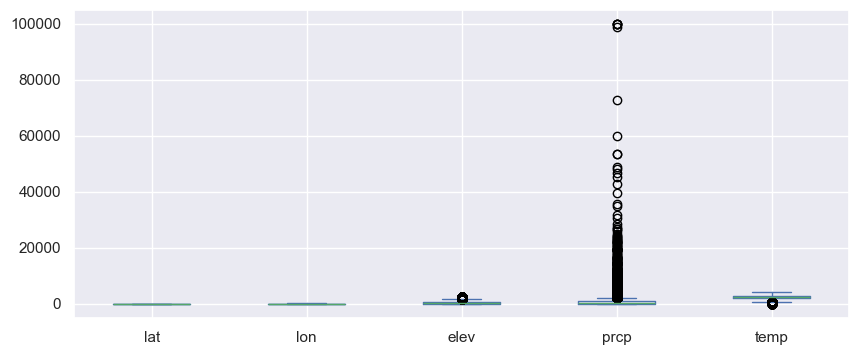

In [39]:
df8.plot(kind = 'box', figsize = (10, 4))

Start by creating a function that removes outliers using a Z-score method.

In [42]:
# Function to remove outliers using Z-score method for specific columns
def remove_outliers_z_score(df, columns, threshold=3):
    """
    Remove outliers using Z-score method for specific columns in a DataFrame.

    Parameters:
    - df: Pandas DataFrame
    - columns: List of column names to consider for outlier removal
    - threshold: Z-score threshold for outlier detection (default is 3)

    Returns:
    - DataFrame without outliers
    """
    # Calculate Z-scores for specified columns
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    
    # Filter rows where any Z-score is greater than threshold
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    
    return filtered_df

In [44]:
df9 =  remove_outliers_z_score(df8, ['lat', 'lon', 'prcp', 'temp', 'elev'])
# Location data (latitude and longitude) must not be removed.

In [46]:
df9.head()

,station_id,lat,lon,elev,prcp,date,temp
0,AG000060390,36.7167,3.25,24.0,1611,1973-01-15,1024.0
1,AG000060390,36.7167,3.25,24.0,3461,1973-02-15,924.0
2,AG000060390,36.7167,3.25,24.0,996,1973-03-15,974.0
3,AG000060390,36.7167,3.25,24.0,491,1973-04-15,1294.0
4,AG000060390,36.7167,3.25,24.0,13,1973-05-15,1754.0


In [48]:
df9.shape

(111307, 7)

<Axes: >

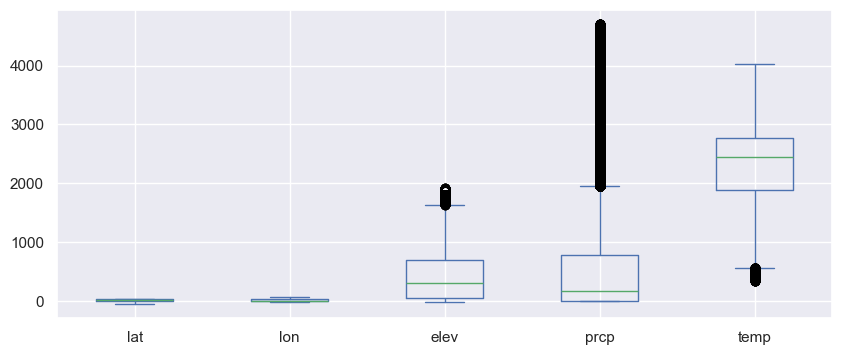

In [50]:
df9.plot(kind = 'box', figsize = (10, 4))

In [52]:
df10 = df9.drop(['station_id', 'date'],axis = 1)
df10.head()

,lat,lon,elev,prcp,temp
0,36.7167,3.25,24.0,1611,1024.0
1,36.7167,3.25,24.0,3461,924.0
2,36.7167,3.25,24.0,996,974.0
3,36.7167,3.25,24.0,491,1294.0
4,36.7167,3.25,24.0,13,1754.0


In [54]:
df10.shape

(111307, 5)

#### Reorder the columns to make precipitation the last column, because it is the dependent variable.

In [57]:
# Reorder columns
df11 = df10[['lon', 'lat', 'elev','temp','prcp']]
df11.head()

,lon,lat,elev,temp,prcp
0,3.25,36.7167,24.0,1024.0,1611
1,3.25,36.7167,24.0,924.0,3461
2,3.25,36.7167,24.0,974.0,996
3,3.25,36.7167,24.0,1294.0,491
4,3.25,36.7167,24.0,1754.0,13


#### This "df11" is now a clean data that we are going to use for machine leanring.

## 6.4) Visualize the data by making some plots and investigate the results

#### The independent variable here are: date, lon, lat, elev, and temp. And 'prcp' is the independent variable to predict. Therefore, plot the precitpitaion gainst the five independent variables.

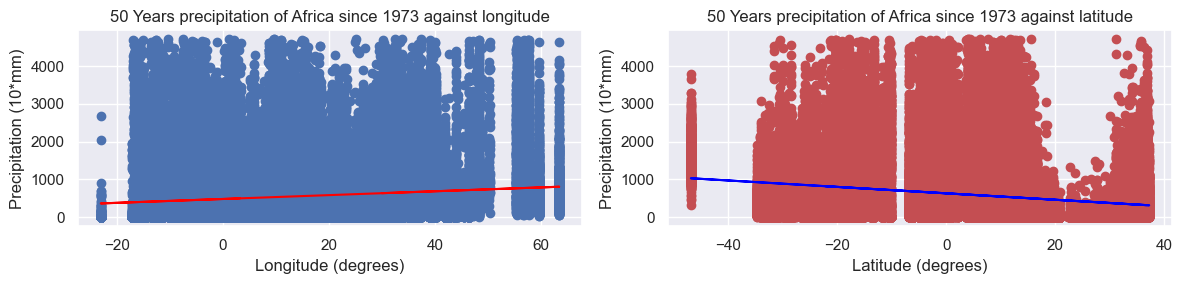

In [78]:
# Create 2 subplot, 1 for each variable
fig, axes = plt.subplots(figsize=(12,3),nrows=1,ncols=2)

# Plot for date vs temp
axes[0].scatter(df11['lon'],df11['prcp'],color="b")
axes[0].set_xlabel("Longitude (degrees)")
axes[0].set_ylabel("Precipitation (10*mm)")
axes[0].set_title("50 Years precipitation of Africa since 1973 against longitude")
plt.savefig("Precipitation against elevation", dpi=300)  # Save the scatter plot

# Plot for bedrooms vs house prices
axes[1].scatter(df11['lat'],df11['prcp'],color="r")
axes[1].set_xlabel("Latitude (degrees)")
axes[1].set_ylabel("Precipitation (10*mm)")
axes[1].set_title("50 Years precipitation of Africa since 1973 against latitude")

# Calculate the trend line
z0 = np.polyfit(df11['lon'], df11['prcp'], 1)  # 1 for linear regression
p0 = np.poly1d(z0)
z1 = np.polyfit(df11['lat'], df11['prcp'], 1)  # 1 for linear regression
p1 = np.poly1d(z1)

# Plot the trend line
axes[0].plot(df11['lon'], p0(df11['lon']), color='red', label='Trend line')
axes[1].plot(df11['lat'], p1(df11['lat']), color='blue', label='Trend line')

# Enhance layout
plt.tight_layout()

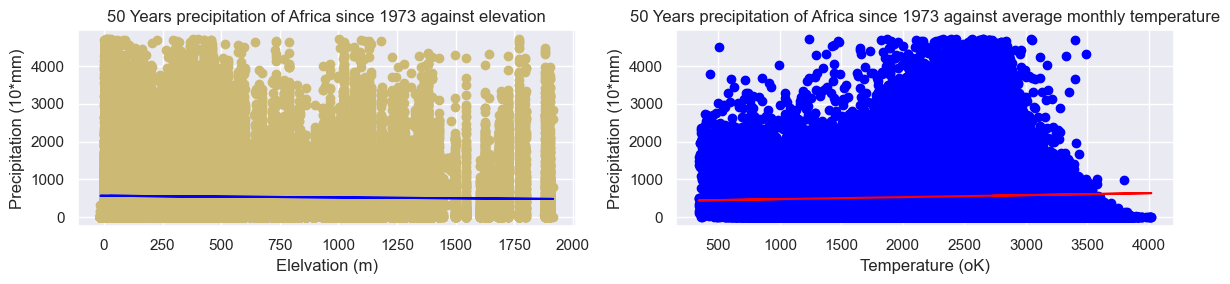

In [76]:
# Create 2 subplot, 1 for each variable
fig, axes = plt.subplots(figsize=(12,3),nrows=1,ncols=2)

# Plot for date vs temp
axes[0].scatter(df11['elev'],df11['prcp'],color="y")
axes[0].set_xlabel("Elelvation (m)")
axes[0].set_ylabel("Precipitation (10*mm)")
axes[0].set_title("50 Years precipitation of Africa since 1973 against elevation")
plt.savefig("Precipitation against elevation", dpi=300)  # Save the scatter plot

# Plot for bedrooms vs house prices
axes[1].scatter(df11['temp'],df11['prcp'],color="blue")
axes[1].set_xlabel("Temperature (oK)")
axes[1].set_ylabel("Precipitation (10*mm)")
axes[1].set_title("50 Years precipitation of Africa since 1973 against average monthly temperature")
plt.savefig("Precipitation against temperature", dpi=300)  # Save the scatter plot

# Calculate the trend line
z2 = np.polyfit(df11['elev'], df11['prcp'], 1)  # 1 for linear regression
p2 = np.poly1d(z2)
z3 = np.polyfit(df11['temp'], df11['prcp'], 1)  # 1 for linear regression
p3 = np.poly1d(z3)

# Plot the trend line
axes[0].plot(df11['elev'], p2(df11['elev']), color='blue', label='Trend line')
axes[1].plot(df11['temp'], p3(df11['temp']), color='red', label='Trend line')

# Enhance layout
plt.tight_layout()

#### Note that PRECIPITATION is our target variabele here. And it is worth noting that from now on we are going to use five machine learning algorithms namely: Linear Regression, Lasso Regression, Ridge Regression, Decision Tree Regressor, Random Forest Regressor, and KNN Regressor.

## 6.5) Normalize the Features and make a cost function

#### Define a function for feature normalization

In [71]:
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalized X values,
    the mean and standard deviation of each feature
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    X_norm = (X - mean)/std
    return X_norm , mean , std

#### Define a funtion generates a cost function for a linear regression model.

In [74]:
def cost_function(X,y,theta):
    """
    Take in a numpy array X,y, theta and generate the cost function of using theta as parameter
    in a linear regression model
    """
    m = len(y)
    pred = X.dot(theta) #computes the predicted output values 'pred' using the input data X and the model parameters theta.
    square_err = (pred - y)**2 #calculates the squared error between the predicted output values and the actual output values y for each training example
    return 1/(2*m) * np.sum(square_err)

## 6.6) Normalize features and Initialize theta

In [77]:
# Convert the dataFrame to numpy array
df12 = df11.values

# Define the number of samples
m = len(df12[:, -1])

# Extract features and target column
X = df12[:, 0:4]
y = df12[:, -1].reshape(m, 1)

# Normalize the feature
X, mean_X2, std_X2 = featureNormalization(X)

# Add bias term (column of ones)
X = np.append(np.ones((m, 1)), X, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize theta
theta = np.zeros((X_train.shape[1], 1))  # Now it's (5, 1) because we added a bias term

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

X_train shape: (89045, 5)
X_test shape: (22262, 5)
y_train shape: (89045, 1)
y_test shape: (22262, 1)
Initial theta shape: (5, 1)


#### Define a function for gradient descent computation

In [80]:
def gradientDescent(X,y,theta,alpha,num_iters):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha

    return theta and the list of the cost of theta during each iteration
    """
    m=len(y)
    J=[]
    for i in range(num_iters):
        pred = X.dot(theta)
        error = np.dot(X.transpose(),(pred -y))
        descent=alpha * 1/m * error
        theta= theta-descent
        J.append(cost_function(X,y,theta))
    return theta, J

#### Define predictor

In [83]:
def predict(x,theta):
    """
    Takes in numpy array of x and theta and return the predicted value of y based on theta
    """
    predictions= np.dot(theta.transpose(),x)
    return predictions[0]

h(x) =547.7537 + 4.3348*x1 + -190.4834*x2


Text(0.5, 1.0, 'Cost function using Gradient Descent')

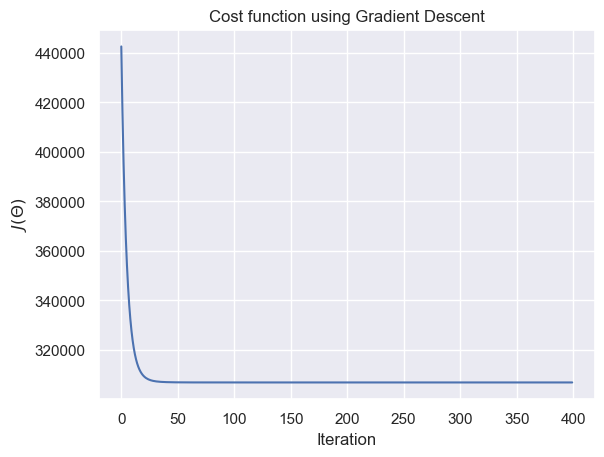

In [85]:
theta, J = gradientDescent(X_test, y_test, theta, 0.1, 400)
print("h(x) ="+str(round(theta[0,0],4))+" + "+str(round(theta[1,0],4))+"*x1 + "+str(round(theta[2,0],4))+"*x2")

plt.plot(J)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

#### See predicted precipitation for a set of dependent variables

In [88]:
# feature normalization of the x values
x_sample = featureNormalization(np.array([3.25,36.7167, 24, 1754]))[0]
x_sample = np.append(np.ones(1), x_sample)
predict3 = predict(x_sample,theta)
print("At (lon, lat) of (3.25,36.7167), 24 meter elevation, and 1754 oK temperature, the predicted precipitation value is "+str(round(predict3,0)) + "mm")

At (lon, lat) of (3.25,36.7167), 24 meter elevation, and 1754 oK temperature, the predicted precipitation value is 720.0mm


## 6.7) Make regularization and prediction

### 6.7.1) Use Linear Regression Without regularization

In [92]:
# Create a numpy array from the dataframe
X = np.array([X]).reshape(-1, 1)
y = 5*X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the test dataset
y_pred = lr.predict(X_test)

# Calculate and print the Mean Squared Error
mse_lr = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with Linear Regression:", mse_lr)

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

Mean Squared Error with Linear Regression: 2.0578626136235268e-26
X_train shape: (445228, 1)
X_test shape: (111307, 1)
y_train shape: (445228, 1)
y_test shape: (111307, 1)
Initial theta shape: (5, 1)


### 6.7.2) Lasso

In [95]:
# Create a numpy array from the dataframe
X = np.array([X]).reshape(-1,1)
y = 5*X
la = Lasso()
la.fit(X_train,y_train)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Lasso Regression
la = Lasso(alpha = 0.1)  # We can adjust the alpha parameter for regularization strength
la.fit(X_train, y_train)

# Predicting on the test dataset
y_pred_la = la.predict(X_test)

# Calculate and print the Mean Squared Error
mse_la = mean_squared_error(y_test, y_pred_la)
print("Mean Squared Error with Lasso Regression:", mse_la)

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

Mean Squared Error with Lasso Regression: 0.010400810653972343
X_train shape: (445228, 1)
X_test shape: (111307, 1)
y_train shape: (445228, 1)
y_test shape: (111307, 1)
Initial theta shape: (5, 1)


### 6.7.2) Rudge

In [98]:
# Create a numpy array from the dataframe
X = np.array([X]).reshape(-1,1)
y = 5*X
lg = Ridge()
lg.fit(X,y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Ridge Regression
y_pred_lg = lg.predict(X_test)

# Calculate and print the Mean Squared Error
mse_lg = mean_squared_error(y_test, y_pred_lg)
print("Mean Squared Error with Ridge Regression:", mse_lg)

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

Mean Squared Error with Ridge Regression: 8.399182881743937e-11
X_train shape: (445228, 1)
X_test shape: (111307, 1)
y_train shape: (445228, 1)
y_test shape: (111307, 1)
Initial theta shape: (5, 1)


### 6.7.3) Decision Tree Regressor 

In [101]:
# Define features and target
X = df11[['lon', 'lat', 'elev', 'temp']]
y = df11['prcp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test_dr = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Regressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Make predictions
y_pred_dr = regressor.predict(X_test)

# Evaluate the model
mse_dr = mean_squared_error(y_test_dr, y_pred_dr)
print(f'Mean Squared Error of Decision Regressor is: {mse_dr}')

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

Mean Squared Error of Decision Regressor is: 692125.1965977909
X_train shape: (77914, 4)
X_test shape: (33393, 4)
y_train shape: (77914,)
y_test shape: (111307, 1)
Initial theta shape: (5, 1)


### 6.7.4) Random Forest Regressor

In [104]:
# Split the data into features (X) and target (y)
X = df11.drop('prcp', axis=1)
y = df11['prcp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error random forest regressor is: {mse_rf}")

# Display feature importances
feature_importances = rf_regressor.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

Mean Squared Error random forest regressor is: 467874.56285027764
Feature: lon, Importance: 0.1216
Feature: lat, Importance: 0.2776
Feature: elev, Importance: 0.0986
Feature: temp, Importance: 0.5021
X_train shape: (89045, 4)
X_test shape: (22262, 4)
y_train shape: (89045,)
y_test shape: (22262,)
Initial theta shape: (5, 1)


### 6.7.5) KNN Regressor

In [106]:
# Split the data into features (X) and target (y)
X = df11.drop('prcp', axis=1)
y = df11['prcp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN Regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_regressor.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for knn regressor is: {mse_knn}")

# Display actual vs predicted values (optional...)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df.head(15))

# Display shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Initial theta shape:", theta.shape)

Mean Squared Error for knn regressor is: 460629.6019980236
        Actual  Predicted
110890     430      172.0
18347       42      189.2
75139      210     1159.4
96469        0       -0.2
133347      10      145.8
90021       15      282.6
2840       980      663.2
98148        0       -0.2
72327       40        5.4
124394      -1       29.8
133882      95      483.6
122204       0      370.0
674          0        0.0
70615      640      625.0
127584       0      908.0
X_train shape: (89045, 4)
X_test shape: (22262, 4)
y_train shape: (89045,)
y_test shape: (22262,)
Initial theta shape: (5, 1)


## 6.8) Print Performances of all 5 ML models

Model: LinearRegression
MSE: 613846.16
RMSE: 783.48
R-squared: 0.06
MAE: 570.59


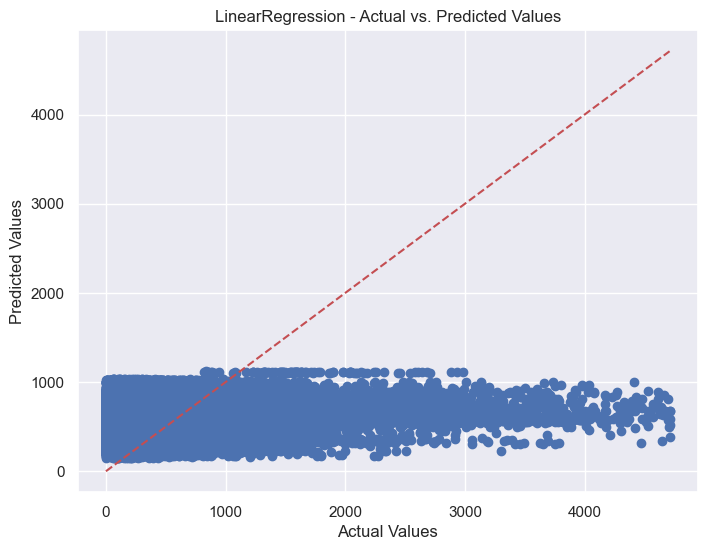

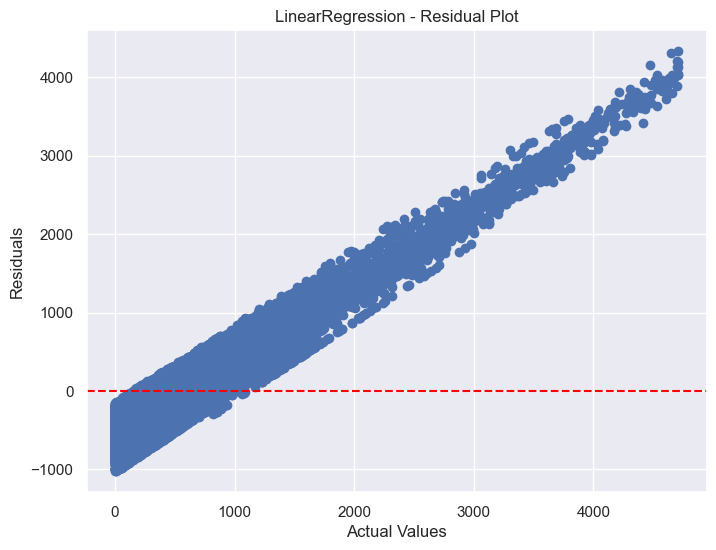

Model: Lasso
MSE: 613843.67
RMSE: 783.48
R-squared: 0.06
MAE: 570.59


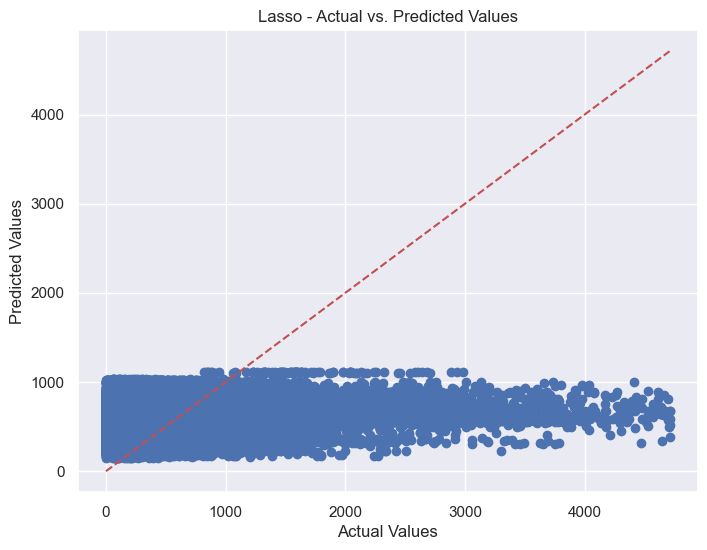

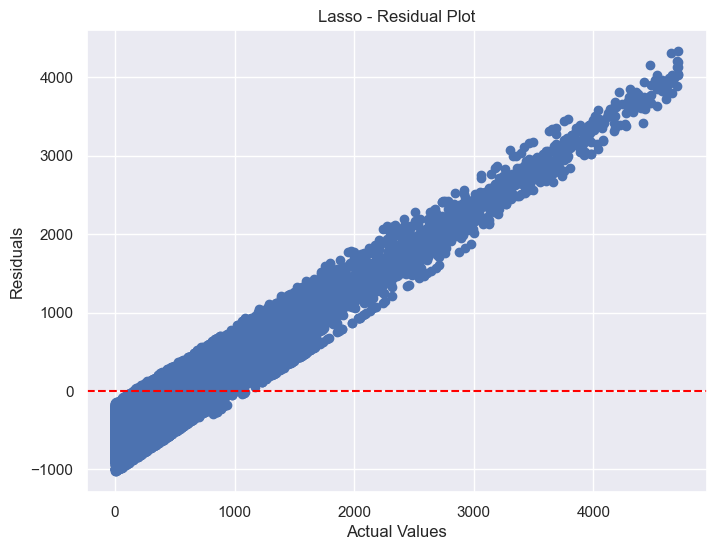

Model: Ridge
MSE: 613846.16
RMSE: 783.48
R-squared: 0.06
MAE: 570.59


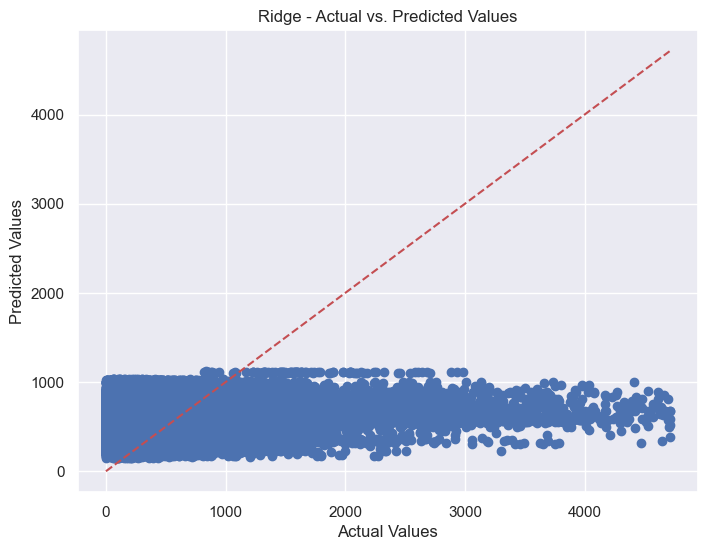

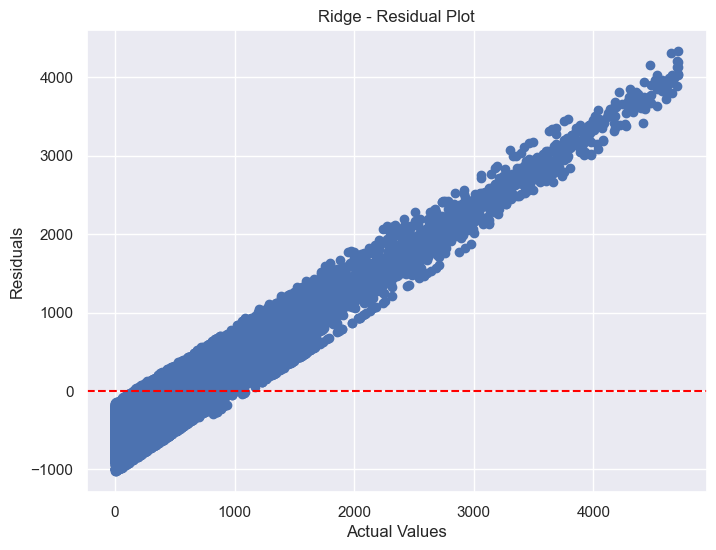

Model: DecisionTreeRegressor
MSE: 691669.63
RMSE: 831.67
R-squared: -0.06
MAE: 488.29


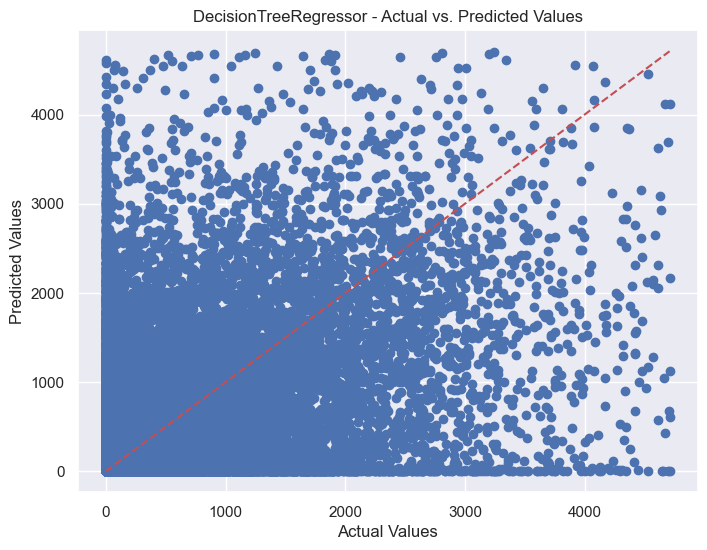

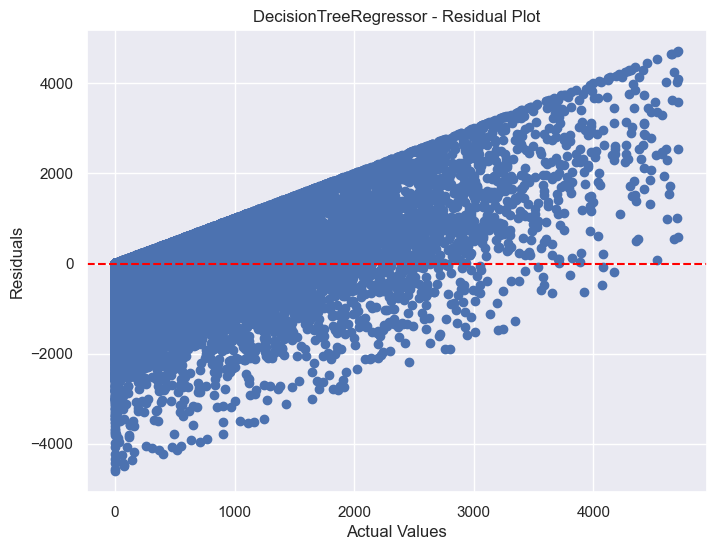

Model: KNeighborsRegressor
MSE: 460629.60
RMSE: 678.70
R-squared: 0.29
MAE: 421.88


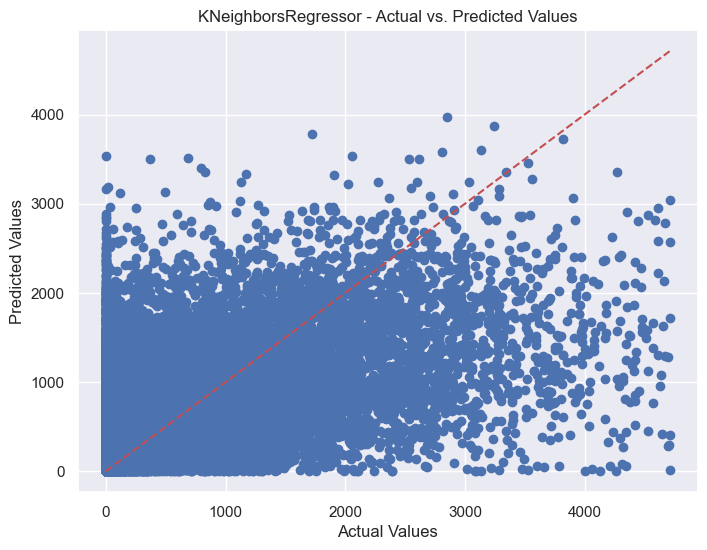

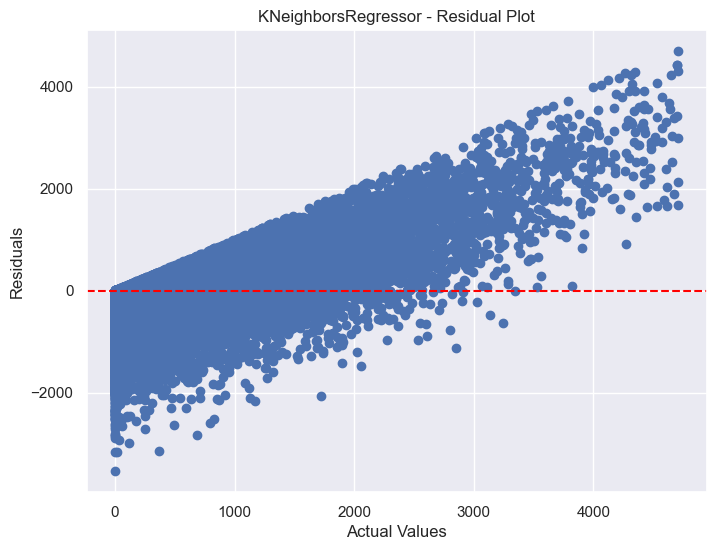

In [117]:
# Make a vaiable with the list of models
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    DecisionTreeRegressor(),
    KNeighborsRegressor()
]

# Loop through each models and plot the prediction, plot the residuals, and print the evaluation metrics.
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Model: {type(model).__name__}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print(f"MAE: {mae:.2f}")

    # Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"{type(model).__name__} - Actual vs. Predicted Values")
    plt.savefig(f"{type(model).__name__}_scatter.jpg", dpi=300)  # Save the scatter plot
    plt.show()

    # Residual Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test - y_pred)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(f"{type(model).__name__} - Residual Plot")
    plt.savefig(f"{type(model).__name__}_residual.jpg", dpi=300)  # Save the residual plot
    plt.show()

# 7) Geospatial visualization

## 7.1) Make preprocessing for mapping

### 7.1.1) Import the necessary packages for geo-visualization

In [ ]:
import geopandas as gpd
import seaborn as sns
%matplotlib inline
from shapely.geometry import Point

### 7.1.2) Create a base map for Africa

Import the data of Ethiopia from local drive and plot it first. Then the overlay comes later.

In [ ]:
africa = "C:/Tamirat_2024/IGSSA_PhD/Y1_S2/2_Special_Topics/Data/Shapefile/A11_Africa.zip"

In [ ]:
type(africa)

In [ ]:
af_gpd1 = gpd.read_file(africa)

In [ ]:
af_gpd1.head()

### 7.1.3) Fix a geographic projection system

Check if the geopandas file has a coordinate system. If not projected, then project it.

In [ ]:
if af_gpd1.crs != "EPSG:4326":
    af_gpd1.crs = {'init': 'EPSG:4326'}
else:
    pass

Plot the regions, just to overlay

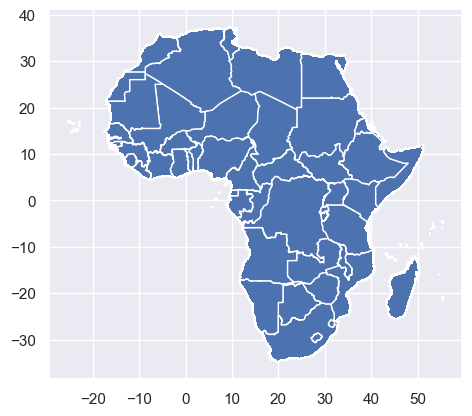

In [53]:
af_gpd1.plot(categorical = False, legend = False)
plt.show()

## 7.2) Make maps

### 7.2.1) Make precipitation map

Convert the dataframes into geopandas dataframes using the coordinate system, the geometry and the longitude latitude columns.

In [ ]:
### 7.2.1) Make precipitation map

C:\Users\tamir\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


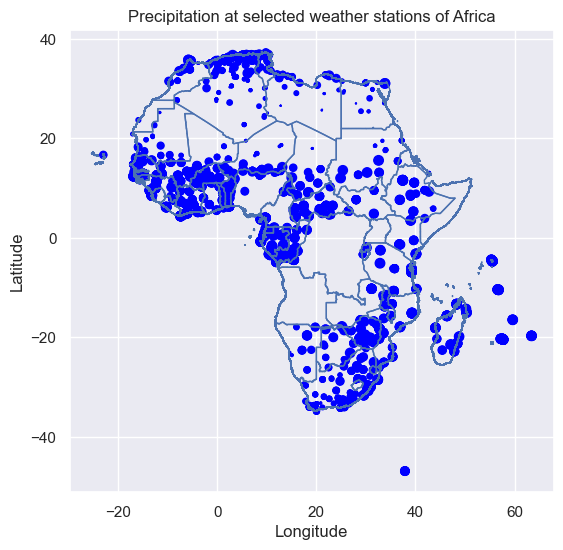

In [113]:
# Plot the maps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot base map
af_gpd1.boundary.plot(ax=ax, linewidth=1)

# Create geometry column for cities
geometry = [Point(xy) for xy in zip(df11['lon'], df11['lat'])]
gdf = gpd.GeoDataFrame(df11, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Plot cities with population-based point sizes
gdf.plot(ax=ax, marker='o', color='blue', markersize=gdf['prcp']/100, alpha = 1, legend  = True)
#gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['temp']/100, alpha = 0.1, legend  = True)

# Customize plot
plt.title('Precipitation at selected weather stations of Africa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 7.2.2) Make Temperature map

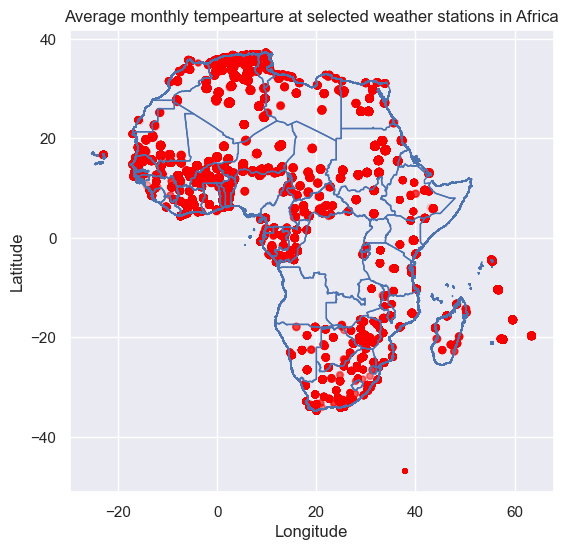

In [116]:
# Plot the maps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot base map
af_gpd1.boundary.plot(ax=ax, linewidth=1)

# Create geometry column for cities
geometry = [Point(xy) for xy in zip(df11['lon'], df11['lat'])]
gdf = gpd.GeoDataFrame(df11, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Plot cities with population-based point sizes
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['temp']/100, alpha = 0.1, legend  = True)

# Customize plot
plt.title('Average monthly tempearture at selected weather stations in Africa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 7.2.3) Make map for each African country

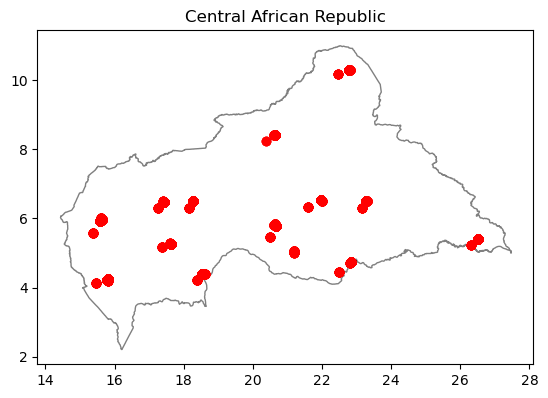

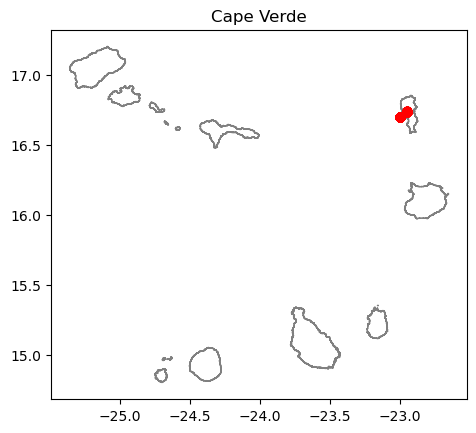

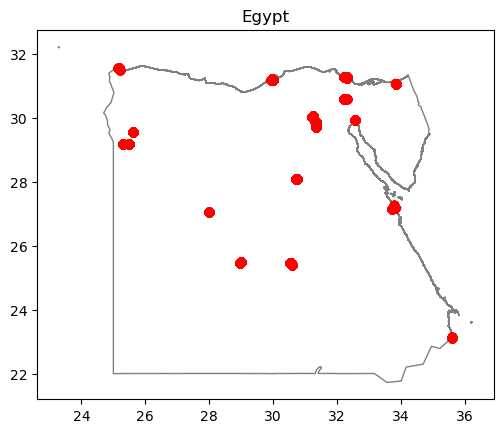

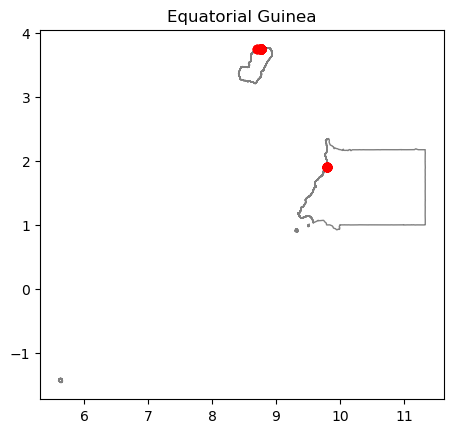

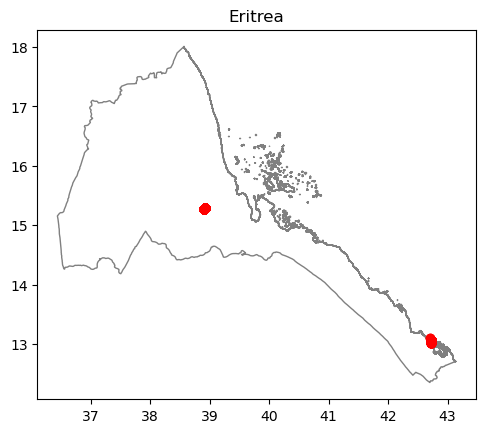

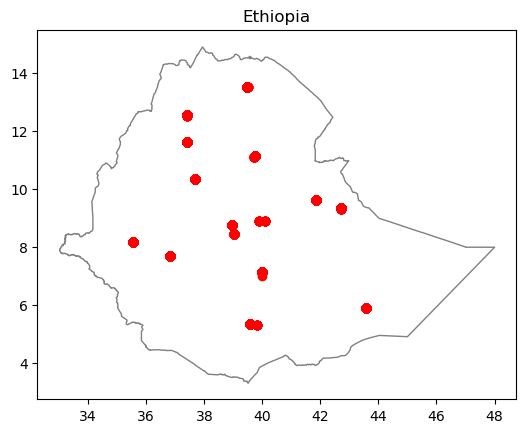

ValueError: aspect must be finite and positive 

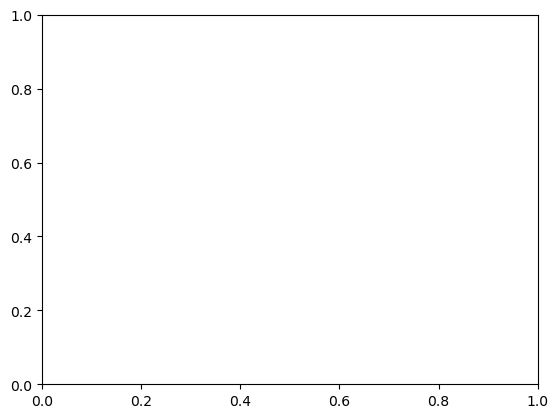

In [484]:
import geopandas as gpd
for df in pdfs5:
    if len(df) > 1:
        # Create coordinates as a tuple
        df['Coordinates'] = list(zip(df.longitude, df.latitude))

        # Transform tuple to points
        df['Coordinates'] = df['Coordinates'].apply(Point)

        # Create a geodataframe
        gdf = gpd.GeoDataFrame(df, geometry='Coordinates')

        # Plot the basemap
        ax = af_gpd1[af_gpd1.NAME_0 == df['country_name'].iloc[0]].plot(color='white', edgecolor='grey')
        ax.set_title(df['country_name'].iloc[0])
        ax.set_aspect('equal')

        # We can now plot our GeoDataFrame.
        gdf.plot(ax=ax, color='blue')
        
        # See the overlapped plot
        plt.show()
    else:
        print(df['country_name'].iloc[0])